# Use Case Claim Frequency Modeling (Python)

Friedrich Loser, February 2024

What are the benefits of machine learning techniques for car insurance pricing? To answer this question, the claims frequency for a large French motor third party liability insurance portfolio is modeled and predicted. In a first classical approach, generalized linear models (GLM) are used and a benchmark is defined. Then, the gradient tree boosting machines (GBM) CatBoost, LightGBM and XGBoost, known for their prediction accuracy, are applied with and without monotone constraints and the explainability of the models is investigated. Finally, artificial neural networks, including the combined actuarial neural network (CANN), are used. It is shown that both neural networks and GBMs can at least be used to improve classical models. Furthermore, the GBMs are shown to be the superior forecasting models, even when monotone constraints are applied to account for plausible tariff structures.

This Python notebook is linked to the R notebook https://www.kaggle.com/floser/glm-neural-nets-and-xgboost-for-insurance-pricing/notebook (version 2 from April 26th, 2020). While it basically uses the same dataset and models, it differs in the data cleaning, the now weighted Poisson deviance, the focus on CatBoost with default values and the hyperparameter tuning of CatBoost, LightGBM and XGBoost.

## Table of Contents
* [1. Prepare data and get ready for modelling](#A1)
* [2. Generalized Linear Models (GLM)](#A2)
* [3. Model champions: Gradient tree boosting machines](#A3)
* [4. Deep Learning Approach with Embeddings and the "CANN"](#A4)
* [5. Summary and Outlook](#A5)
<br>
<a id="A"></a>

<a id="A1"></a>
## 1. Prepare data and get ready for modelling

<img src="https://i.postimg.cc/d13q5ywF/TF-DALL-E-2023-10-24-23-43-07-Photorealistic-wide-format-illustration-inside-a-modern-sophisticat.png" style="float: center; width: '100%'; max-width: '800px'">

### 1.1 Import required libraries and set device-parameters (cpu/gpu)

In [1]:
import os
# Set environment variable to ignore all warnings
os.environ['PYTHONWARNINGS'] = 'ignore'

seed= 123 # 2023 # 42 # for reproducible random numbers
%matplotlib inline
%config InlineBackend.figure_format = 'png'
#%config InlineBackend.figure_format = 'svg'

import locale
locale.setlocale(locale.LC_ALL, "")

import subprocess
import time
import random

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy.stats import uniform, loguniform
!pip install pyarrow_hotfix # due to PyArrow security vulnerability 
import pyarrow_hotfix

# Explainable AI methods
import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG, Image

sns.set(rc={'figure.figsize':(12,7)})
sns.set_theme()

# Models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Tuning
from sklearn.model_selection import GridSearchCV

In [2]:
# Set device-parameters cpu/gpu according to the selected accelerator (Kaggle notebook option):

device_LGB = 'cpu'
device_XGB = 'cpu'

# Execute the nvidia-smi command to check for NVIDIA GPUs
try:
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode == 0 and 'NVIDIA' in result.stdout:
        device_LGB = 'gpu'
        device_XGB = 'cuda'
        print("NVIDIA GPU is available and supports LightGBM, XGBoost and TensorFlow")
    else:
         print("NVIDIA GPU is not available.")
except FileNotFoundError:
    print("nvidia-smi command not found (i.e. NVIDIA GPU is not selected, see notebook options).")

nvidia-smi command not found (i.e. NVIDIA GPU is not selected, see notebook options).


### 1.2 Read dataset and correct claim number 

We analyse data for motor third party liability claims (MTPL) in France. The data is available via the R library CASdatasets by Christophe Dutang. The specific datasets are called FreMTPL2freq and FreMTPL2sev. The former contains the information on the insurance policy and claims frequency and the latter the corresponding information on claims severity.

The claim counts on the insurance policies with policy IDs ≤ 24500 in the dataset FreMTPL2freq do not have claim severity counterparts in the dataset FreMTPL2sev and thus seem not to be correct. For this reason we work with the claim counts extracted from FreMTPL2sev. More details can be found here (https://www.kaggle.com/code/floser/comparing-claims-fremtpl2freq-sev) and in Chapter 13.1 of "Statistical Foundations of Actuarial Learning and its Applications" by Mario Wüthrich and Michael Merz (open access book, 2023).

In [3]:
# read frequency data
df_raw = pd.read_csv("../input/french-motor-claims-datasets-fremtpl2freq/freMTPL2freq.csv")
df_raw.IDpol = df_raw.IDpol.astype(int) # policy ID should be integer

# data preparations and corrections as used in Schelldorfer and Wüthrich (2019)
df_raw["Exposure"] = np.minimum(1, df_raw.Exposure)
df_raw["ClaimNb"] = np.minimum(4, df_raw.ClaimNb)

# import folds from the linked R notebook (to obtain the same subsamples and reproduce some results)
df_folds = pd.read_csv("../input/fremtpl2freq-folds/freMTPL2freq_folds.csv")
df_folds.IDpol = df_folds.IDpol.astype(int) # policy ID should be integer
df = pd.merge(df_raw, df_folds, how='inner', on='IDpol')

print("\nNumber of data rows and columns: ", df.shape)
print("\nCheck the end of the data set (possibly corrupted data):")
df.tail(6) # view end of dataset


Number of data rows and columns:  (678013, 13)

Check the end of the data set (possibly corrupted data):


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fold
678007,6114325,0,0.005479,E,6,4,40,68,B12,Regular,2733,R93,2
678008,6114326,0,0.002740,E,4,0,54,50,B12,Regular,3317,R93,3
678009,6114327,0,0.002740,E,4,0,41,95,B12,Regular,9850,R11,5
678010,6114328,0,0.002740,D,6,2,45,50,B12,Diesel,1323,R82,5
678011,6114329,0,0.002740,B,4,0,60,50,B12,Regular,95,R26,3
678012,6114330,0,0.002740,B,7,6,29,54,B12,Diesel,65,R72,5


In [4]:
# take claim number from severity file (see https://www.kaggle.com/code/floser/comparing-claims-fremtpl2freq-sev)
sev = pd.read_csv("../input/fremtpl2sev/freMTPL2sev.csv")
sev["ClaimNb"] = 1
sev_agg = sev.groupby("IDpol").sum("ClaimNb").drop(columns=['ClaimAmount'])
# checks, sums and counts
sev_agg.head()

,ClaimNb
IDpol,
139,1
190,1
414,1
424,2
463,1


In [5]:
# left join with claims frequency data (exposures, features and without questionable ClaimNb). 
df = pd.merge(df.drop(columns=['ClaimNb']), sev_agg, on="IDpol", how="left").fillna(0)

# data preparations and corrections as used in Schelldorfer and Wüthrich (2019)
df['ClaimNb'] = df['ClaimNb'].clip(upper=4)
df['Exposure'] = df['Exposure'].clip(upper=1)

# Show summary statistics
df.describe()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,fold,ClaimNb
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.528545,6.454631,7.044265,45.499122,59.761502,1792.422405,2.997021,0.038945
std,1.641783e+06,0.364081,2.050906,5.666232,14.137444,15.636658,3958.646564,1.413916,0.205026
min,1.000000e+00,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,1.000000,0.000000
25%,1.157951e+06,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,2.000000,0.000000
50%,2.272152e+06,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,3.000000,0.000000
75%,4.046274e+06,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,4.000000,0.000000
max,6.114330e+06,1.000000,15.000000,100.000000,100.000000,230.000000,27000.000000,5.000000,4.000000


In [6]:
# count number of missing values in data set
df.isna().sum().sum()

0

Result: No missing values. Thus there is no need for replacements (as necessary for generalized linear models (GLMs) and artificial neural networks (NNs).

### 1.3 Explorative data analysis

#### 1.3.1 Exposure, claims and claim frequency

Since this jupyther notebook is about modeling claims frequency, let us first examine the number of claims and the exposure at policy level:

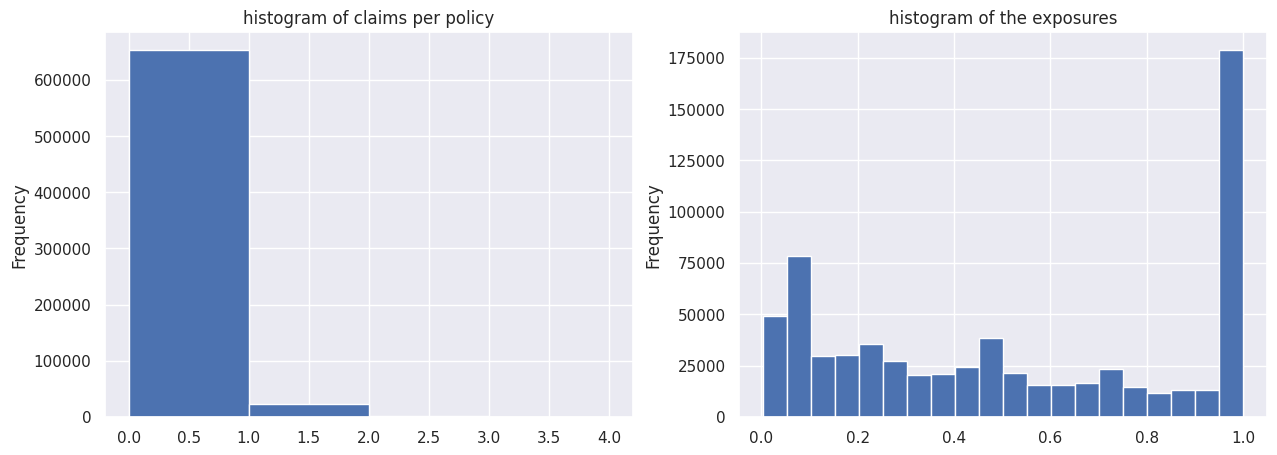

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.set_title("histogram of claims per policy")
ax2.set_title("histogram of the exposures")
df.ClaimNb.plot.hist(bins=4,ax=ax1)
df.Exposure.plot.hist(bins=20, ax=ax2)
pass

In [8]:
# View distribution of all claims 
df.ClaimNb.value_counts()

ClaimNb
0.0    653069
1.0     23571
2.0      1298
3.0        62
4.0        13
Name: count, dtype: int64

As expected, most policies are free of claims. We observe a significant proportion of policies with an exposure value of less than 0.5 and therefore expect a large difference between the exposure-weighted and the unweighted claims frequency. In addition we calculate the annualized claims frequency variable. 

In [9]:
df['Frequency'] = df['ClaimNb'] / df['Exposure']

#### 1.3.2 Car brand, car age and fuel

To focus on new car effects, all cars from the age of four belong to the same group in the following plot

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


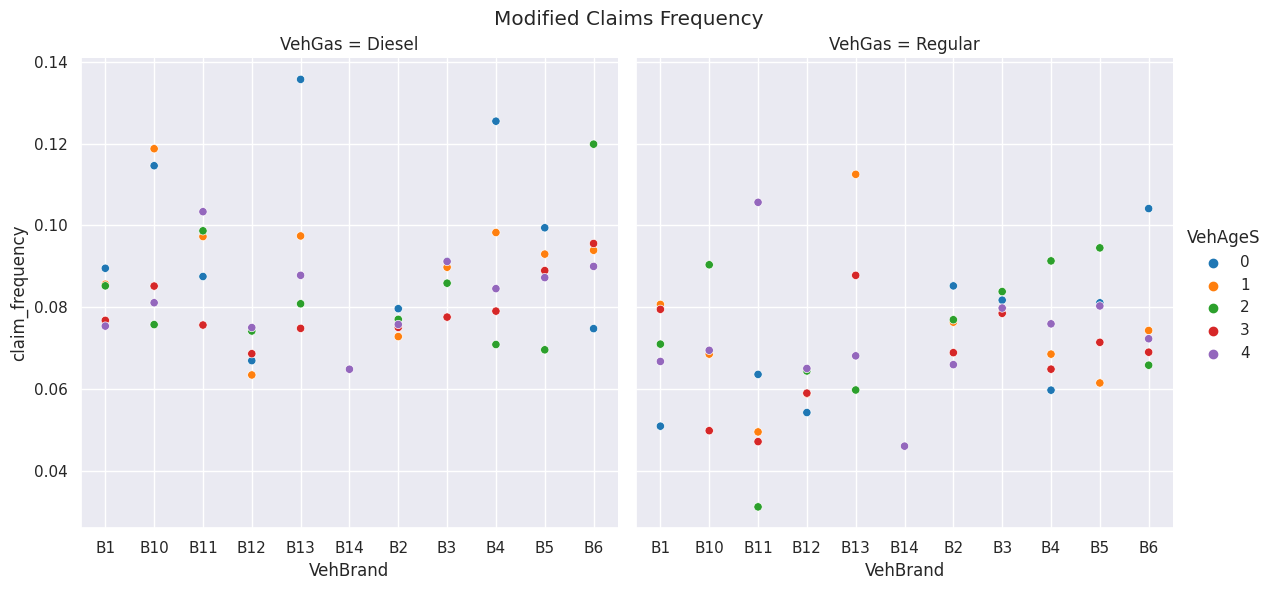

In [10]:
df_eda = df.copy()
df_eda["VehAgeS"] = np.minimum(4, df_eda.VehAge)
df_eda = df_eda.groupby(["VehBrand", "VehAgeS", "VehGas"]).agg(claim_frequency=pd.NamedAgg(column="ClaimNb", aggfunc=sum),
                                                         expo=pd.NamedAgg(column="Exposure", aggfunc=sum))
df_eda.claim_frequency = df_eda.claim_frequency / df_eda.expo
df_eda = df_eda.query("expo >= 100") # exlude groups with low exposure

# rp is a FacetGrid. relplot is a nice organized way to use it
rp = sns.relplot(data=df_eda, x='VehBrand', y='claim_frequency', col='VehGas', hue="VehAgeS",
                 palette="tab10", kind='scatter', height=6)
rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle('Modified Claims Frequency')
pass

While the unadjusted data at this point shows a segment with an extremely high claims frequency of 66% for non-diesel new vehicles of the B12 brand, this now looks quite unspectacular after the data adjustment and there is no longer any need to treat the "B12RN" segment in a special way as in https://www.kaggle.com/code/floser/glm-neural-nets-and-xgboost-for-insurance-pricing/notebook?scriptVersionId=32747844 (version 2).

#### 1.3.3 BonusMalus (claims free discount)

Since we want to restrict later models to a monotonically increasing behaviour of "BonusMalus", we should take a closer look at this feature.

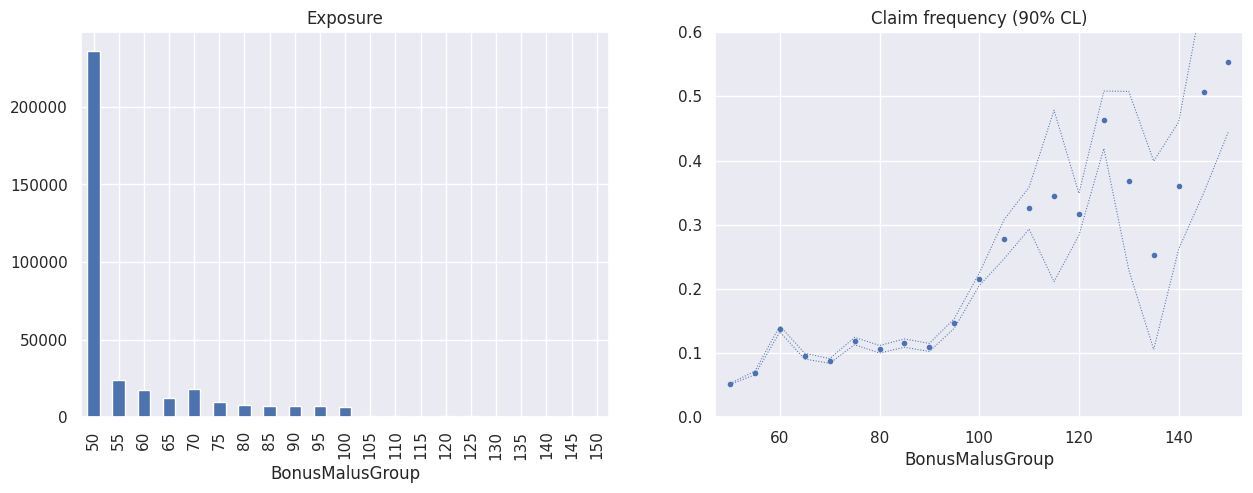

In [11]:
# Prepare data and plot

# round feature values for grouping
df_eda = df.copy()
df_eda["BonusMalus"] = np.minimum(df_eda.BonusMalus, 150)
df_eda["BonusMalusGroup"] = np.round(df_eda.BonusMalus/5, 0).astype(int) * 5

# group by BonusMalusGroup and calculate 90% confidence interval (1.645 sigma)
frequency = df_eda.groupby("BonusMalusGroup").ClaimNb.sum() / df_eda.groupby("BonusMalusGroup").Exposure.sum()
z = 1.645 * df_eda.groupby("BonusMalusGroup").ClaimNb.sum()**0.5 / df_eda.groupby("BonusMalusGroup").Exposure.sum()
frequency = pd.DataFrame(frequency, columns=["Frequency"])
frequency["Upper"] = frequency.Frequency + z
frequency["Lower"] = frequency.Frequency - z

# Generate plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.set_title("Exposure")
ax2.set_title("Claim frequency (90% CL)")
df_eda.groupby("BonusMalusGroup").Exposure.sum().plot.bar(ax=ax1)
labels = ax1.get_xticklabels()
frequency.plot(y=["Frequency", "Upper", "Lower"], ylim=(0, 0.6), xlim=(50-3, 153),
               style=[".", ":", ":"], color="bbb", legend=False, lw=0.75, ax=ax2)
pass

By far most contracts have reached the “50” group with the highest no-claims discount. As expected, this group has the lowest claims frequency. The claims frequency curve rises from 5% to over 50% for the worst BonusMalus group, although not monotonically.

### 1.4 Feature preprocessing for GLM

We perform the feature preprocessing according to Schelldorfer and Wüthrich (2019):

In [12]:
dat2 = df.copy()
dat2["AreaGLM"] = dat2.Area.factorize()[0]
dat2["VehPowerGLM"] = np.minimum(9, dat2.VehPower)
# VehAgeGLM: 3 classes
mapping = {k: 3 if k>=11 else (2 if k>= 1 else 1) for k in range(111)}
dat2["VehAgeGLM"] = dat2.VehAge.map(mapping)
dat2["BonusMalusGLM"] = np.minimum(150, dat2.BonusMalus)
dat2["DensityGLM"] = np.log(dat2.Density)
dat2.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fold,ClaimNb,Frequency,AreaGLM,VehPowerGLM,VehAgeGLM,BonusMalusGLM,DensityGLM
0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,1,0.0,0.0,0,5,1,50,7.104144
1,3,0.77,D,5,0,55,50,B12,Regular,1217,R82,5,0.0,0.0,0,5,1,50,7.104144
2,5,0.75,B,6,2,52,50,B12,Diesel,54,R22,1,0.0,0.0,1,6,2,50,3.988984
3,10,0.09,B,7,0,46,50,B12,Diesel,76,R72,1,0.0,0.0,1,7,1,50,4.330733
4,11,0.84,B,7,0,46,50,B12,Diesel,76,R72,2,0.0,0.0,1,7,1,50,4.330733


In [13]:
#dat2.VehPowerGLM.value_counts()

### 1.5 Evaluation metrics and helper functions

Since the exposure is so different, we will exposure-weight the Poisson deviance and the corresponding functions.

In [14]:
# Modified function PDX: Weighted Poisson Deviance
def PDW(pred, obs, ex=None):
    if ex is None:
        ex = np.ones(len(obs))
    deviance = 200 * np.sum(ex * (pred - obs + np.log((obs / pred) ** obs))) / np.sum(ex)
    return deviance

In [15]:
# Function PDW2: Print Poisson Deviance learn/test
def PDW2(txt, l_c, l_x, l_e, t_c, t_x, t_e):
    print("%s, Learn/Test: %.2f %% / %.2f %%" % (txt, PDW(l_c, l_x, l_e), PDW(t_c, t_x, t_e)))

In [16]:
# Function CF2: Print claim frequency
def CF2(txt, l_c, l_x, t_c, t_x):
    print("%s: %.2f %% / %.2f %%" % (txt, sum(l_c)/sum(l_x)*100, sum(t_c)/sum(t_x)*100))

In [17]:
# Function Benchmark.GLM2: Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
def Benchmark_GLM2(txt, pred):
    index = ((PDW(pred, test2.ClaimNb, test2.Exposure) - PDW(test2.fit_cf, test2.ClaimNb, test2.Exposure)) 
             / (PDW(test2.fitGLM2, test2.ClaimNb, test2.Exposure) - PDW(test2.fit_cf, test2.ClaimNb, test2.Exposure))) * 100
    II.append(index)
    mname.append(txt)
    print("GLM2-Improvement-Index (PD test) of %s: %.1f %%" % (txt, index)) 

Helper functions

In [18]:
# model names list
mname = []

# GLM2-Improvment-Index
II = []

# Dictionary for PD and model names
dict = {'improvement': II, 'modelname': mname}

In [19]:
def plot_eval(d,x1,x2,t): 
    """
    This function graphically represents the forecast quality of the fitted models.
    Input parameter: Dictionary with model names, PD and Text
    """
    df_eval = pd.DataFrame(d)
    sns.set_style('darkgrid')
    plt.title("GLM2-Improvement-Index of the fitted models: " + t)
    sns.barplot(data = df_eval, x = "improvement", y = "modelname", color = 'magenta')
    plt.xlim(x1, x2)
    plt.show()

In [20]:
def plot_feature_importance(model, data, top_n=20, model_name=''): 
    """
    This function extracts and plots the most important features (if method feature_importance_ is available) 
    """
    # Extract the most important features and create a Series for plotting
    FI = pd.Series(model.feature_importances_, index=data.columns).nlargest(top_n)
    # Plot the feature importances
    FI.plot(kind='barh')
    plt.gca().invert_yaxis()
    text = 'Model {}: Top {} most important features'.format(model_name, top_n)
    plt.title(text)
    plt.xlabel('Importance')
    plt.show()

### 1.6 Splitting and encoding data

In this case, the learning sample randomly takes up $80\,\%$ and the test sample $20\,\%$ of the data records. We also divide the learning sample into a training sample and a validation sample, which is later used for "early stopping", a form of regularisation used to avoid overfitting when training an ML model with an iterative method such as gradient descent.

In [21]:
# Defining learn and test sample based on previously defined folds
learn2 = dat2.loc[dat2.fold != 5,].copy()    # 80%
test2 = dat2.loc[dat2.fold == 5,].copy()     # 20%
CF2("Claim Frequency (Actual) Learn/Test", learn2.ClaimNb, learn2.Exposure, test2.ClaimNb, test2.Exposure)

Claim Frequency (Actual) Learn/Test: 7.37 % / 7.38 %


In [22]:
# Convert categorical variable into dummy/indicator variables.
df_ml = pd.get_dummies(df, drop_first=False, dtype='int')
print(df_ml.shape)
df_ml.head()

(678013, 51)


,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,fold,ClaimNb,Frequency,Area_A,Area_B,Area_C,Area_D,Area_E,Area_F,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,VehBrand_B3,VehBrand_B4,VehBrand_B5,VehBrand_B6,VehGas_Diesel,VehGas_Regular,Region_R11,Region_R21,Region_R22,Region_R23,Region_R24,Region_R25,Region_R26,Region_R31,Region_R41,Region_R42,Region_R43,Region_R52,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,1,0.10,5,0,55,50,1217,1,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3,0.77,5,0,55,50,1217,5,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,5,0.75,6,2,52,50,54,1,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10,0.09,7,0,46,50,76,1,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,11,0.84,7,0,46,50,76,2,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [23]:
# generate sample with encoded data
learn = df_ml.loc[df_ml.fold != 5,].copy()    # 80%
test = df_ml.loc[df_ml.fold == 5,].copy()     # 20%
# Additionally, let's divide learn into train and validation (e.g. to use it for early stopping)
train = df_ml.loc[df_ml.fold < 4,].copy()    # 60%
val = df_ml.loc[df_ml.fold == 4,].copy()    # 20%
CF2("Claim Frequency (Actual) Train/Val", train.ClaimNb, train.Exposure, val.ClaimNb, val.Exposure)

Claim Frequency (Actual) Train/Val: 7.39 % / 7.29 %


In [24]:
# ML-convention: Generate separate datasets for labels (y) and features (X)

no_feature_list=['IDpol', 'ClaimNb', 'Exposure', 'Frequency', 'fold']

# labels 
y_train = train.ClaimNb
y_val = val.ClaimNb
y_test = test.ClaimNb
y_learn = learn.ClaimNb
# features
X_train = train.drop(no_feature_list, axis=1)
X_val = val.drop(no_feature_list, axis=1)
X_test = test.drop(no_feature_list, axis=1)
X_learn = learn.drop(no_feature_list, axis=1)

# Get feature names from encoded data
feature_names = X_learn.columns

# Display first observations of the learning sample
X_learn.head(3)

,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_A,Area_B,Area_C,Area_D,Area_E,Area_F,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,VehBrand_B3,VehBrand_B4,VehBrand_B5,VehBrand_B6,VehGas_Diesel,VehGas_Regular,Region_R11,Region_R21,Region_R22,Region_R23,Region_R24,Region_R25,Region_R26,Region_R31,Region_R41,Region_R42,Region_R43,Region_R52,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,5,0,55,50,1217,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,6,2,52,50,54,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,0,46,50,76,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### 1.7 Model INT (intercept-only)

The model "INT" consists solely of the intercept (i.e. no model, just mean value). It should give an impression of how much or little of the overall variation can be explained by classical and machine learning models.


In [25]:
# Model INT "predictions"
cf = sum(learn2.ClaimNb) / sum(learn2.Exposure) # claim frequency
learn2["fit_cf"] = cf * learn2.Exposure
test2["fit_cf"] = cf * test2.Exposure
# Print Poisson Deviance
PDW2("Poisson Deviance INT", learn2.fit_cf, learn2.ClaimNb,learn2.Exposure, test2.fit_cf, test2.ClaimNb,test2.Exposure)

# Print claim frequency actual vs predicted (Intercept model)
CF2("Claim Frequency INT, Test-Sample, Actual/Predicted", test2.ClaimNb, test2.Exposure, test2.fit_cf, test2.Exposure)

Poisson Deviance INT, Learn/Test: 31.19 % / 31.09 %
Claim Frequency INT, Test-Sample, Actual/Predicted: 7.38 % / 7.37 %


<a id="A2"></a>
## 2. Generalized Linear Models (GLM)

<img src="https://i.postimg.cc/C13b4Sjp/DALL-E-2024-02-09-18-20-43-GLM-male-and-female-actuary-intensely-focused-on-a-large-glowing-com.webp" style="float: center; width: '100%'; max-width: '800px'">

"The industry has widely adopted generalized linear models (GLMs) as a standard approach to modeling claims" is stated in this 2019 machine learning report: https://www.soa.org/globalassets/assets/files/resources/research-report/2019/machine-learning-methods.pdf . Thus we consider GLMs as well known and give it a try on this data set.

### 2.1 Basic "GLM2" (focus on driver age)

In [26]:
model = smf.glm("ClaimNb ~ C(VehPowerGLM) + C(VehAgeGLM) + BonusMalusGLM + VehBrand + VehGas + DensityGLM +  C(Region) + AreaGLM + DrivAge + np.log(DrivAge) +  I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4)",  family=sm.families.Poisson(), offset = np.log(learn2.Exposure), data=learn2)
# Optimizer: https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Poisson.fit.html
d_glm2 = model.fit(method='newton') # same results with 'nm', 'IRLS'
d_glm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               542962
Model:                            GLM   Df Residuals:                   542914
Model Family:                 Poisson   Df Model:                           47
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -86134.
Date:                Tue, 13 Feb 2024   Deviance:                   1.3166e+05
Time:                        11:53:39   Pearson chi2:                 9.29e+05
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01062
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -6.7365      0.343    -19.632      0.000      -7.409      -6.064
C(VehPowerGLM)[T.5]     0.0607      0.024      2.484      0.013       0.013       0.109
C(VehPowerGLM)[T.6]     0.0917      0.024      3.827      0.000       0.045       0.139
C(VehPowerGLM)[T.7]     0.0960      0.024      4.047      0.000       0.050       0.142
C(VehPowerGLM)[T.8]     0.1266      0.034      3.759      0.000       0.061       0.193
C(VehPowerGLM)[T.9]     0.2570      0.027      9.654      0.000       0.205       0.309
C(VehAgeGLM)[T.2]       0.0166      0.034      0.487      0.626      -0.050       0.083
C(VehAgeGLM)[T.3]      -0.1679      0.037     -4.586      0.000      -0.240      -0.096
VehBrand[T.B10]        -0.0383      0.045     -0.856      0.392      -0.126       0.049
VehBrand[T.B11]         0.1790      0.046      3.863      0.000       0.088       0.270
VehBrand[T.B12]        -0.2796      0.024    -11.456      0.000      -0.327      -0.232
VehBrand[T.B13]         0.0004      0.051      0.008      0.994      -0.099       0.100
VehBrand[T.B14]        -0.3030      0.104     -2.920      0.004      -0.506      -0.100
VehBrand[T.B2]         -0.0074      0.019     -0.383      0.702      -0.045       0.030
VehBrand[T.B3]          0.0379      0.027      1.417      0.156      -0.015       0.090
VehBrand[T.B4]          0.0305      0.036      0.838      0.402      -0.041       0.102
VehBrand[T.B5]          0.0770      0.031      2.489      0.013       0.016       0.138
VehBrand[T.B6]          0.0408      0.034      1.182      0.237      -0.027       0.108
VehGas[T.Regular]      -0.1689      0.015    -11.321      0.000      -0.198      -0.140
C(Region)[T.R21]       -0.0260      0.129     -0.202      0.840      -0.278       0.226
C(Region)[T.R22]        0.1272      0.068      1.868      0.062      -0.006       0.261
C(Region)[T.R23]       -0.0401      0.080     -0.499      0.617      -0.197       0.117
C(Region)[T.R24]       -0.0230      0.031     -0.735      0.462      -0.084       0.038
C(Region)[T.R25]       -0.0233      0.059     -0.395      0.693      -0.139       0.092
C(Region)[T.R26]        0.0416      0.065      0.644      0.520      -0.085       0.168
C(Region)[T.R31]        0.0163      0.044      0.371      0.711      -0.070       0.103
C(Region)[T.R41]       -0.1066      0.057     -1.864      0.062      -0.219       0.006
C(Region)[T.R42]       -0.0031      0.117     -0.026      0.979      -0.233       0.226
C(Region)[T.R43]       -0.1413      0.191     -0.740      0.459      -0.515       0.233
C(Region)[T.R52]        0.0206      0.038      0.540      0.589      -0.054       0.095
C(Region)[T.R53]       -0.0006      0.037     -0.015      0.988      -0.073       0.072
C(Region)[T.R54]        0.0369      0.048      0.767      0.443      -0.057       0.131
C(R

In [27]:
# make predictions
learn2["fitGLM2"] = d_glm2.predict(learn2) * learn2.Exposure
test2["fitGLM2"] = d_glm2.predict(test2) * test2.Exposure
df["fitGLM2"] = d_glm2.predict(dat2) * df.Exposure

# Print claim frequency actual vs predicted
CF2("Claim Frequency GLM2, Test-Sample, Actual/Predicted", test2.ClaimNb, test2.Exposure, test2.fitGLM2, test2.Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance GLM2", learn2.fitGLM2, learn2.ClaimNb,learn2.Exposure, test2.fitGLM2, test2.ClaimNb,test2.Exposure)

Claim Frequency GLM2, Test-Sample, Actual/Predicted: 7.38 % / 7.38 %
Poisson Deviance GLM2, Learn/Test: 29.60 % / 29.58 %


This is only a small improvement compared to the "no model" INT with a weighted Poisson deviance of 31.19% / 31.09%. Obviously, there are no known characteristics that can clearly predict damage. This is quite common with insurance risks. Otherwise they would hardly be insurable.

As in the linked R notebook, below we measure the performance of new models using the **GLM2-Improvement-Index**, which relates the new model's weighted Poisson deviance improvement over INT to the corresponding GLM2-INT-improvement: (NewModel-INT)/(GLM2-INT). Therefore, GLM2 improvement over INT is our reference. For example, a GLM2 improvement index of 120 of a new model means that the new model is 20% better at reducing the weighted Poisson deviation than the GLM2, or in simple terms, is 20% better.

### 2.2 "GLM4" featuring neural net residual analyses

The interactions in this model were found using neural network residual analyzes, see "From Generalized Linear Models to Neural Networks, and Back" by Mario Wüthrich (SSRN-Preprint 3491790, 11.12.2019)

In [28]:
model = smf.glm("ClaimNb ~ AreaGLM + C(VehPowerGLM) * C(VehAgeGLM) + C(VehAgeGLM) * VehBrand + VehGas * C(VehAgeGLM) + DensityGLM + C(Region) + BonusMalusGLM * np.log(DrivAge) + np.log(BonusMalusGLM) + I(BonusMalusGLM^2) + I(BonusMalusGLM^3) + I(BonusMalusGLM^4) + DrivAge + I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4)", family=sm.families.Poisson(), offset = np.log(learn2.Exposure), data=learn2)
d_glm4 = model.fit(method='newton')
#print(d_glm4.summary())

In [29]:
learn2["fitGLM4"] = d_glm4.predict(learn2) * learn2.Exposure
test2["fitGLM4"] = d_glm4.predict(test2) * test2.Exposure

# Print Poisson Deviance
PDW2('Poisson Deviance GLM4', learn2.fitGLM4, learn2.Exposure, learn2.ClaimNb, test2.fitGLM4,test2.ClaimNb, test2.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark_GLM2("GLM4", test2.fitGLM4)

Poisson Deviance GLM4, Learn/Test: 218.29 % / 29.45 %
GLM2-Improvement-Index (PD test) of GLM4: 108.5 %


The GLM4 model was developed on the basis of the unadjusted data. On the basis of the adjusted data, the gain in additional predictive power decreases sharply and GLM4 is only slightly better than our reference model GLM2.

### 2.3 "GLM5" featuring gradient tree boosting residual analyses

The interactions in this model were found with XGBoost residual analyzes using the EIX package (source: Chapter 4.2 of  https://www.kaggle.com/code/floser/glm-neural-nets-and-xgboost-for-insurance-pricing/notebook, V2).

In [30]:
model = smf.glm("ClaimNb ~ AreaGLM + C(VehPowerGLM) * C(VehAgeGLM) + C(VehAgeGLM) * VehBrand + VehGas * C(VehAgeGLM) + DensityGLM + C(Region) + BonusMalusGLM * np.log(DrivAge) + C(VehAgeGLM) * np.log(BonusMalusGLM) + I(BonusMalusGLM^2) + I(BonusMalusGLM^3) + I(BonusMalusGLM^4)  + DrivAge * DensityGLM + I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4)", family=sm.families.Poisson(), offset = np.log(learn2.Exposure), data=learn2)
d_glm5 = model.fit(method='newton')
#print(d_glm5.summary())

In [31]:
learn2["fitGLM5"] = d_glm5.predict(learn2) * learn2.Exposure
test2["fitGLM5"] = d_glm5.predict(test2) * test2.Exposure

# Print Poisson Deviance
PDW2('Poisson Deviance GLM5', learn2.fitGLM5, learn2.ClaimNb,learn2.Exposure,  test2.fitGLM5,test2.ClaimNb,test2.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark_GLM2("GLM5", test2.fitGLM5)

Poisson Deviance GLM5, Learn/Test: 29.44 % / 29.44 %
GLM2-Improvement-Index (PD test) of GLM5: 108.6 %


Like GLM4, the GLM5 model was also developed based on the unadjusted data. Based on the cleaned data, the gain in additional predictive power decreases sharply and GLM5 is only slightly better than our reference model GLM2.

Both models have a very similar Poisson deviance and the observed improvements appear to be the limit of classical methods.

<a id="A3"></a>
## 3. Model champions: Gradient tree boosting machines

<img src="https://i.postimg.cc/k4Gwhjk4/T-DALL-E-2023-10-24-22-42-17-Photo-of-an-intense-Olympic-100-meter-race-set-against-the-vastness-o.png" style="float: center; width: '100%'; max-width: '800px'">

With “Gradient Tree Boosting” an usually quite small decision tree is initially calculated and an attempt is made to successively reduce the residuals with a large number of iterations. The result is averaged, with a new iteration result being included with a small weight equal to the so-called “learning rate” and the process therefore learns slowly and must be carefully “tuned”. 

Powerful implementations of this principle can be found in the gradient tree boosting **model champions CatBoost, lightGBM and XGBoost**, which can be used in R and Python. These three tools are significantly faster than previous implementations due to the good parallelization and differ (among other things) in their approach to the step-by-step construction of the trees. LightGBM uses a very efficient histogram-based decision process, which can and should also be activated with XGBoost. CatBoost is particularly suitable for the efficient processing of categorical features and often delivers fast and very good results even with standard settings. 

While the hyperparameter tuning of LightGBM and especially XGBoost benefits greatly from GPU support, we encounter difficulties with CatBoost when running on GPU and therefore train the latter exclusively on CPU.

### 3.1 Basic CatBoost model

#### 3.1.1 Data preprocessing

In [32]:
# generate catboost specific "pool" data based on encoded data (ML-standard. CatBoost could process not encoded data)
learn_pool = Pool(data=X_learn, label=y_learn/learn.Exposure, weight=learn.Exposure)
train_pool = Pool(data=X_train, label=y_train/train.Exposure, weight=train.Exposure)
val_pool  = Pool(data=X_val, label=y_val/val.Exposure, weight=val.Exposure)
test_pool = Pool(data=X_test, label=y_test/test.Exposure, weight=test.Exposure)

#### 3.1.2 Fitting and evaluating default CatBoost model

In [33]:
model_cb1 = CatBoostRegressor(objective='Poisson', random_seed=seed) 

tic = time.time()
model_cb1.fit(learn_pool, logging_level='Silent')
print("time (sec):" + "%6.0f" % (time.time() - tic))

print(model_cb1.get_all_params()) 

time (sec):    86
{'nan_mode': 'Min', 'eval_metric': 'Poisson', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'random_score_type': 'NormalWithModelSizeDecrease', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 123, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Poisson', 'learning_ra

In [34]:
learn["fitCB1"] = model_cb1.predict(learn_pool) * learn.Exposure
test["fitCB1"] = model_cb1.predict(test_pool) * test.Exposure

# Print Poisson Deviance
PDW2('Poisson Deviance CB1-unconstraint', learn.fitCB1, learn.ClaimNb,learn.Exposure, test.fitCB1,test.ClaimNb,test.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark_GLM2("CB1-unconstraint", test.fitCB1)

Poisson Deviance CB1-unconstraint, Learn/Test: 28.17 % / 28.74 %
GLM2-Improvement-Index (PD test) of CB1-unconstraint: 155.2 %


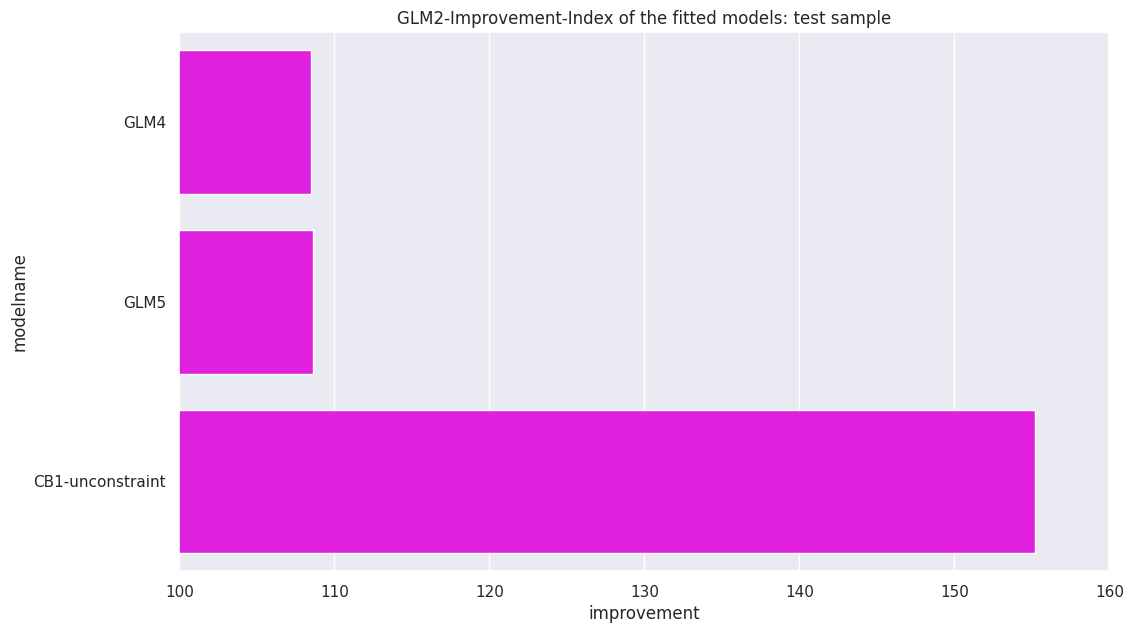

In [35]:
plot_eval(dict, 100, 160, "test sample")

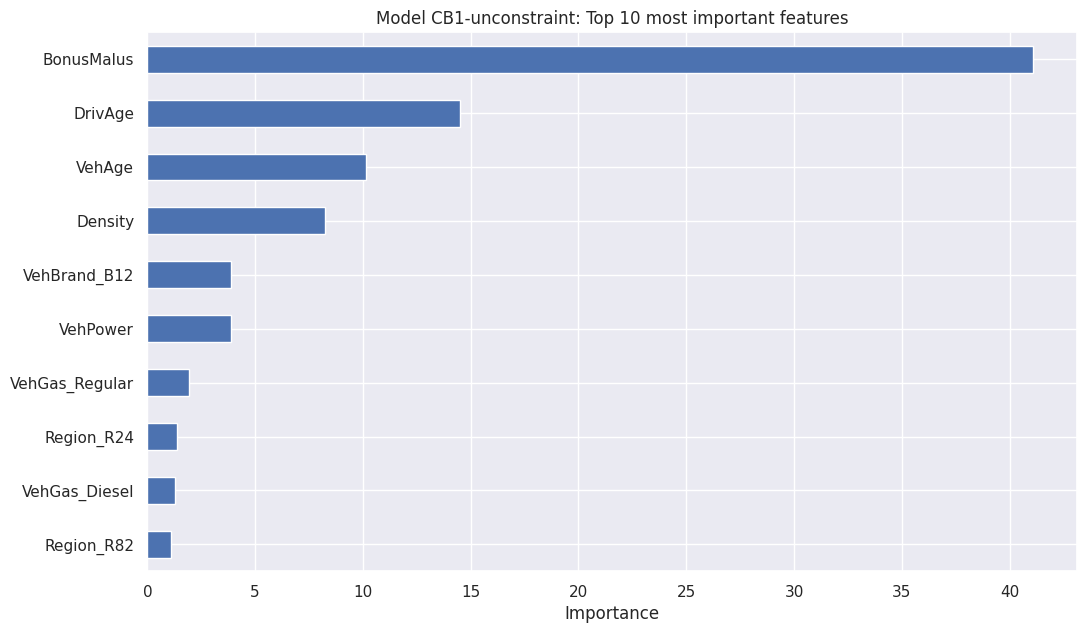

In [36]:
plot_feature_importance(model_cb1, X_learn, 10, "CB1-unconstraint")

#### 3.1.3 Explaining the predictions with SHAP

In [37]:
# define SHAP tree  explainer
explainer1 = shap.TreeExplainer(model_cb1)
shap_values1 = explainer1.shap_values(X_test)

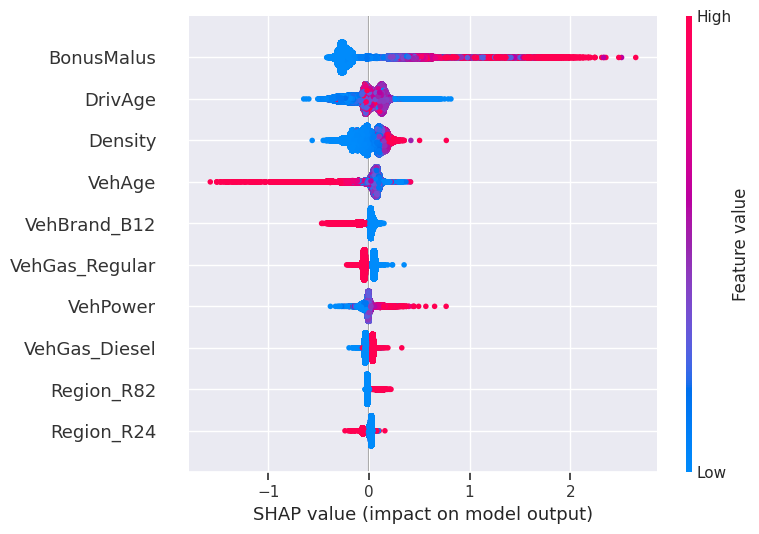

In [38]:
# summarize the effects of all the features
shap.summary_plot(shap_values1, X_test, max_display=10)

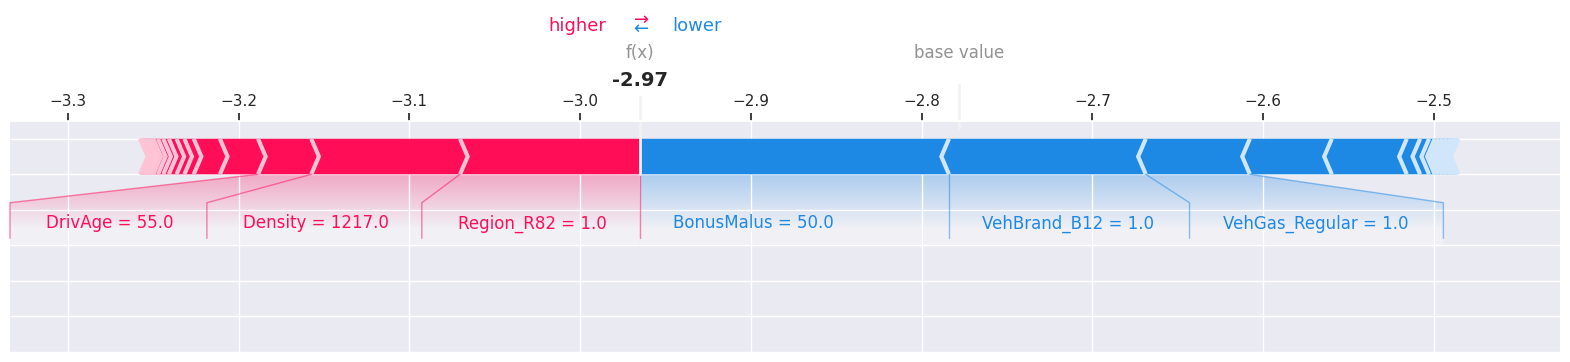

In [39]:
# visualize the first prediction's explanation (on log scale)
shap.force_plot(explainer1.expected_value, shap_values1[0,:], X_test.iloc[0,:], matplotlib=True)

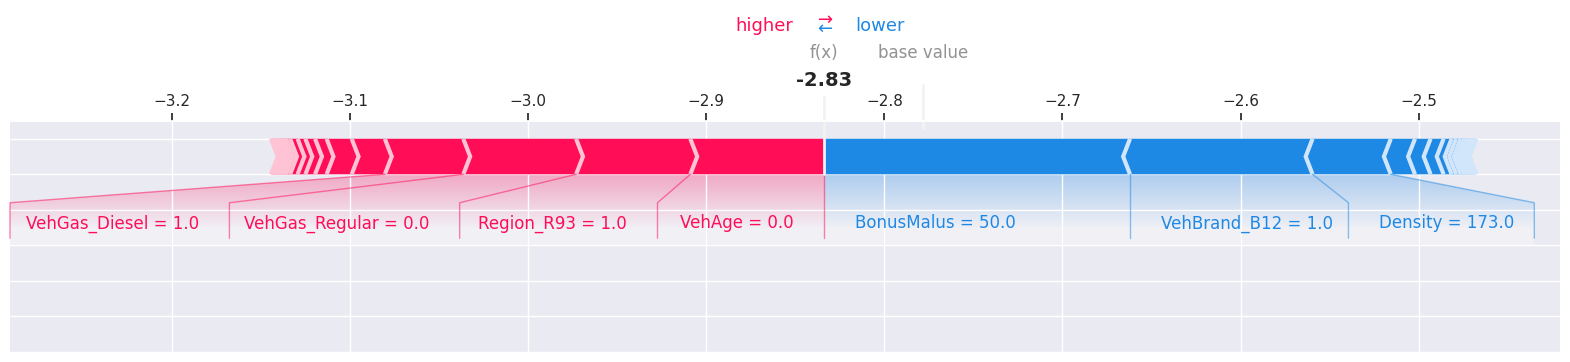

In [40]:
# visualize the second prediction's explanation (on log scale)
shap.force_plot(explainer1.expected_value, shap_values1[1,:], X_test.iloc[1,:], matplotlib=True)

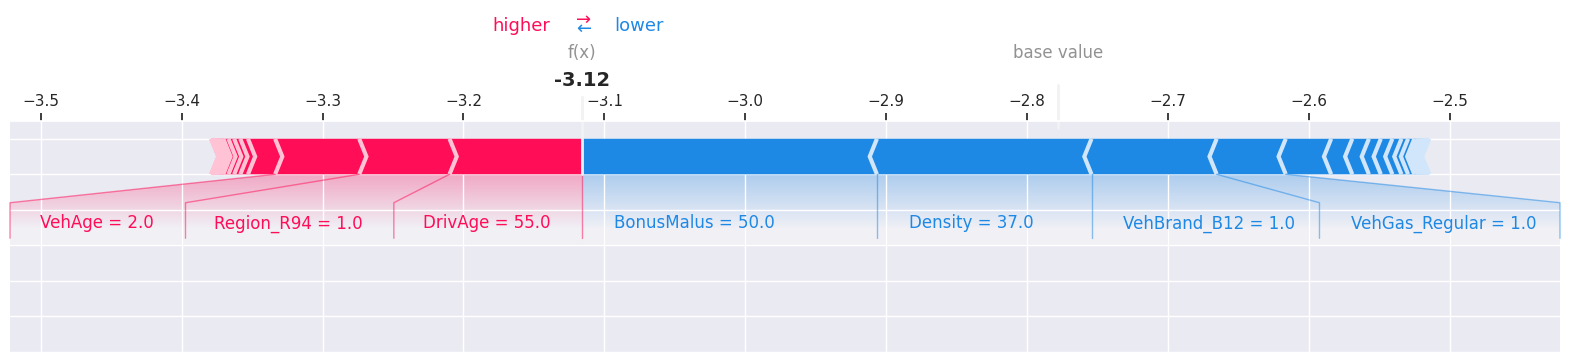

In [41]:
# visualize the third prediction's explanation (on log scale)
shap.force_plot(explainer1.expected_value, shap_values1[2,:], X_test.iloc[2,:], matplotlib=True)

### 3.2 CatBoost with montone constraints

#### 3.2.1 Create monotonic constraints vector

In [42]:
# Create monotonic constraints vector: increasing: +1, decreasing: -1, unconstraint: 0
mtc = np.zeros(len(X_learn.columns))
mtc[3] = 1  # BonusMalus increasing
X_learn.iloc[0:1, 3] # Check position in data frame

0    50
Name: BonusMalus, dtype: int64

#### 3.2.2 Fitting and evaluating constraint CatBoost model

In [43]:
model_cb2 = CatBoostRegressor(objective='Poisson', monotone_constraints = mtc, random_seed=seed) 

tic = time.time()
model_cb2.fit(learn_pool, logging_level='Silent')
print("time (sec):" + "%6.0f" % (time.time() - tic))

print(model_cb2.get_all_params()) 

time (sec):    95
{'nan_mode': 'Min', 'eval_metric': 'Poisson', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'random_score_type': 'NormalWithModelSizeDecrease', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'monotone_constraints': {'3': 1}, 'use_best_model': False, 'random_seed': 123, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0.009999999776482582, 'min_data_

In [44]:
learn["fitCB2"] = model_cb2.predict(learn_pool) * learn.Exposure
test["fitCB2"] = model_cb2.predict(test_pool) * test.Exposure

# Print Poisson Deviance
PDW2('Poisson Deviance CB2', learn.fitCB2, learn.ClaimNb,learn.Exposure, test.fitCB2,test.ClaimNb,test.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark_GLM2("CB2", test.fitCB2)

Poisson Deviance CB2, Learn/Test: 28.65 % / 29.09 %
GLM2-Improvement-Index (PD test) of CB2: 132.0 %


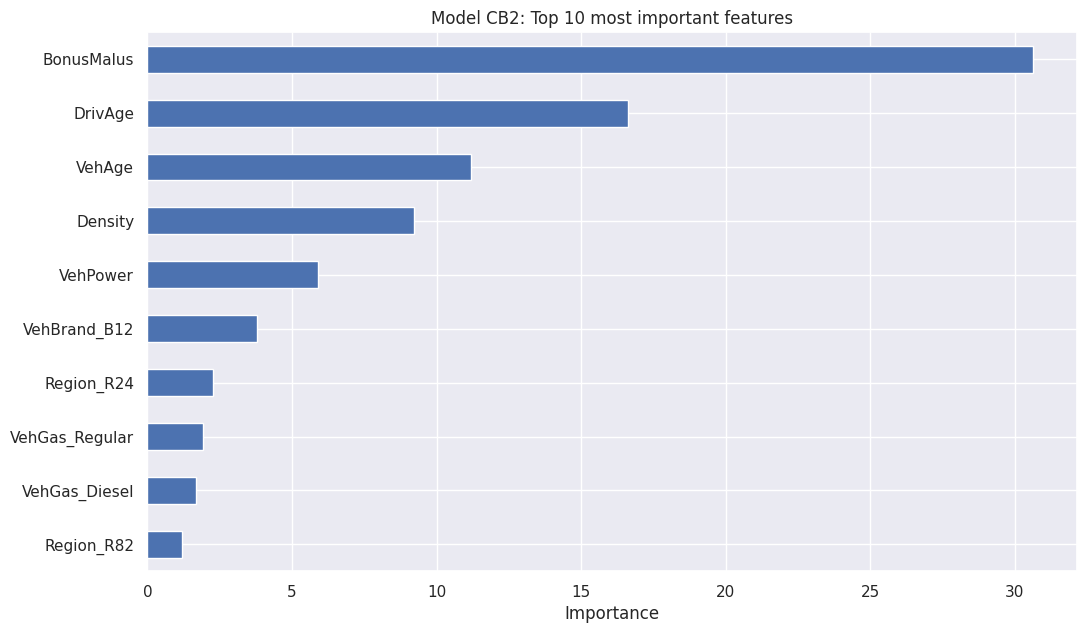

In [45]:
plot_feature_importance(model_cb2, X_learn, 10, "CB2")

Compared to the unconstrained model CB1, the feature importance of BonusMalus is reduced (but still most important). This is an example of how montonic constraints generally reduce the importance of a feature and thus the informative value of the corresponding model. 

#### 3.2.3 Explaining the constraint predictions with SHAP

In [46]:
# define SHAP tree  explainer
explainer2 = shap.TreeExplainer(model_cb2)
shap_values2 = explainer2.shap_values(X_test)

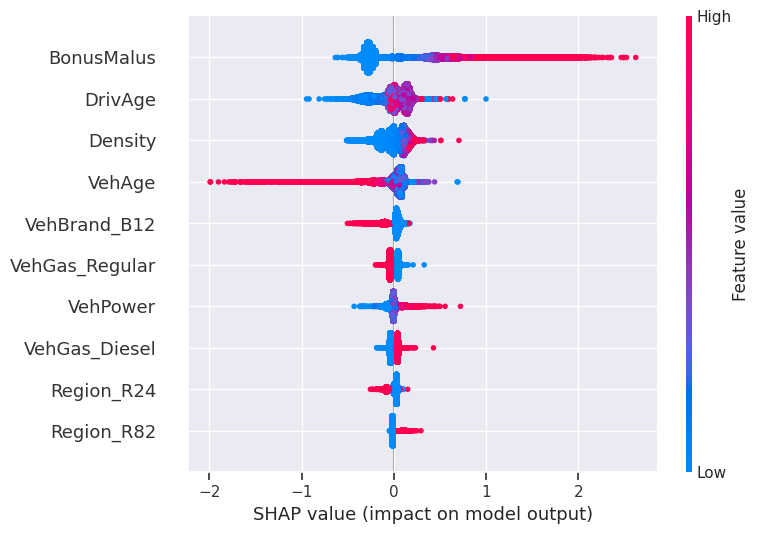

In [47]:
# summarize the effects of all the features
shap.summary_plot(shap_values2, X_test, max_display=10)

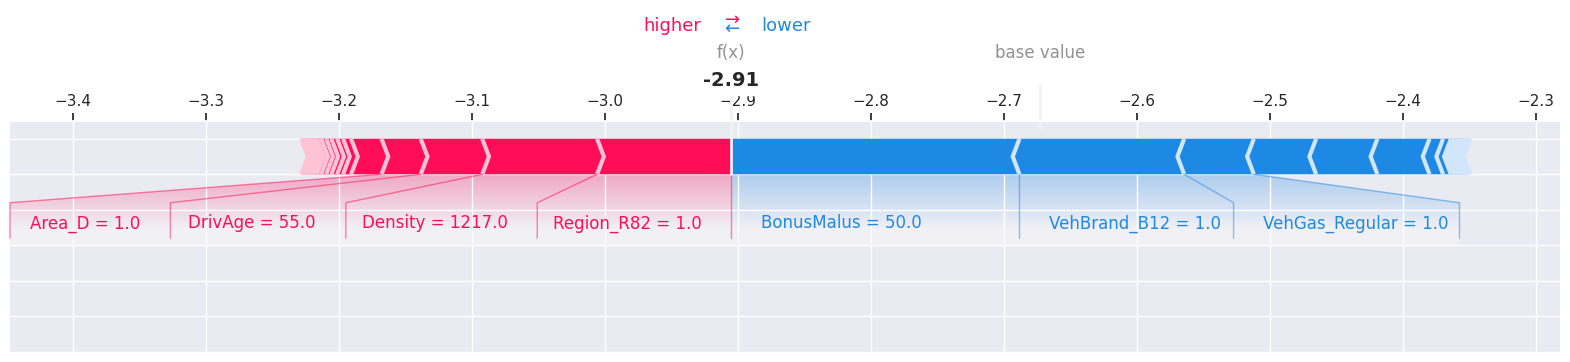

In [48]:
# visualize the first prediction's explanation (on log scale)
shap.force_plot(explainer2.expected_value, shap_values2[0,:], X_test.iloc[0,:], matplotlib=True)

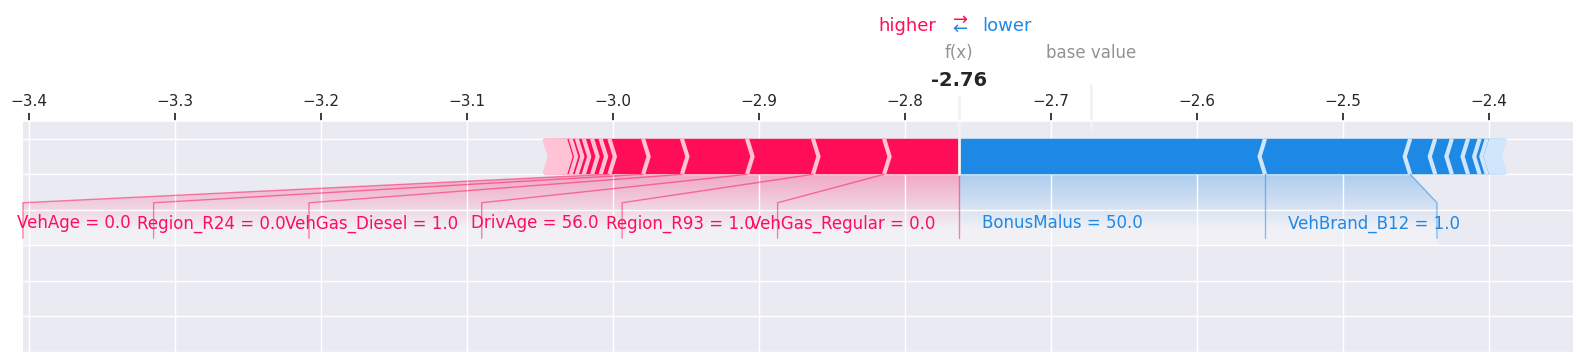

In [49]:
# visualize the second prediction's explanation (on log scale)
shap.force_plot(explainer2.expected_value, shap_values2[1,:], X_test.iloc[1,:], matplotlib=True)

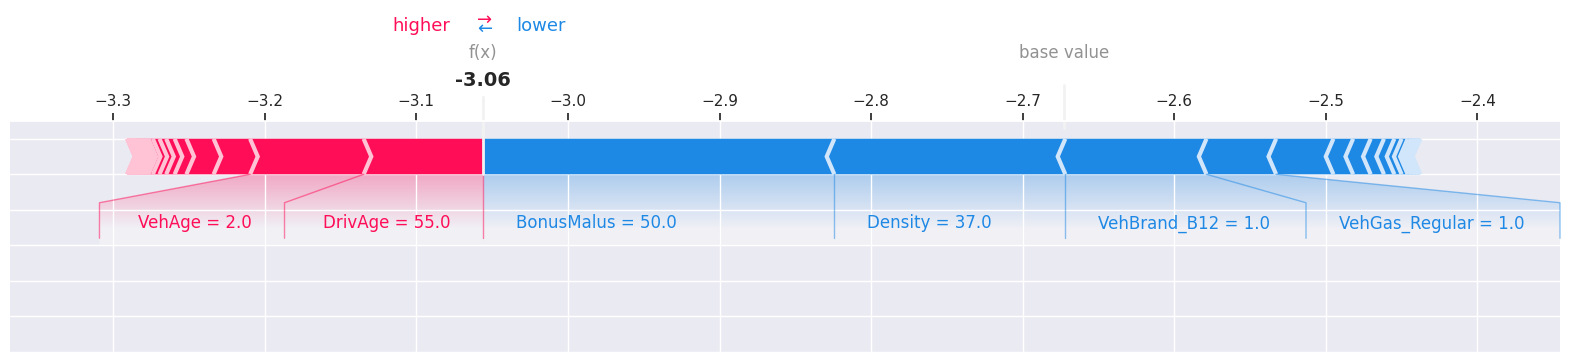

In [50]:
# visualize the third prediction's explanation (on log scale)
shap.force_plot(explainer2.expected_value, shap_values2[2,:], X_test.iloc[2,:], matplotlib=True)

In [51]:
# Compare with feature values and predictions 
test.head(3)

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,fold,ClaimNb,Frequency,Area_A,Area_B,Area_C,Area_D,Area_E,Area_F,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,VehBrand_B3,VehBrand_B4,VehBrand_B5,VehBrand_B6,VehGas_Diesel,VehGas_Regular,Region_R11,Region_R21,Region_R22,Region_R23,Region_R24,Region_R25,Region_R26,Region_R31,Region_R41,Region_R42,Region_R43,Region_R52,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94,fitCB1,fitCB2
1,3,0.77,5,0,55,50,1217,5,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.039695,0.042154
11,27,0.87,7,0,56,50,173,5,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.051148,0.054904
20,47,0.03,6,2,55,50,37,5,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.001330,0.001412


### 3.3 CatBoost with early stopping

In [52]:
model_cb3 = CatBoostRegressor(objective='Poisson', early_stopping_rounds=20, monotone_constraints = mtc, random_seed=seed) 

tic = time.time()
model_cb3.fit(train_pool, eval_set=val_pool, logging_level='Silent')
print("time (sec):" + "%6.0f" % (time.time() - tic))

print("best iteration:", model_cb3.get_best_iteration()) 

time (sec):    38
best iteration: 470


In [53]:
train["fitCB3"] = model_cb3.predict(train_pool) * train.Exposure
test["fitCB3"] = model_cb3.predict(test_pool) * test.Exposure

# Print Poisson Deviance
PDW2('Poisson Deviance CB3 early stopping', train.fitCB3, train.ClaimNb,train.Exposure, test.fitCB3,test.ClaimNb,test.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark_GLM2("CB3 early stopping", test.fitCB3)

Poisson Deviance CB3 early stopping, Learn/Test: 28.88 % / 29.08 %
GLM2-Improvement-Index (PD test) of CB3 early stopping: 132.5 %


### 3.4 Hyperparameter-tuning CatBoost

In the following, we perform a hyperparameter optimization with a grid search and cross-validation. To shorten the runtime, the grid is quite small. This was preceded by a randomized search over a larger grid (not shown).

In [54]:
# Hyperparameter search range for CatBoost
param_grid_CB ={'learning_rate': [0.07,0.1,0.15], 'depth':[3,4] }

# Define variables for results reports
sel_params_CB = ['param_learning_rate','param_depth','mean_test_score','rank_test_score']

In [55]:
# CatBoostRegressor: Hyper parameter optimization with GridSearchCV
tic = time.time()

CB_rs = GridSearchCV(CatBoostRegressor(iterations=500, objective='Poisson', monotone_constraints = mtc), 
                           param_grid_CB, cv=4, n_jobs=-1)
CB_rs.fit(X=X_learn, y=y_learn/learn.Exposure, sample_weight=learn.Exposure, logging_level='Silent')

# Print the runtime as well as the five best hyper parameter constellations
print("time (sec):" + "%6.0f" % (time.time() - tic))
print("Best hyper parameters:",CB_rs.best_params_)
pd.DataFrame(CB_rs.cv_results_)[sel_params_CB].sort_values("rank_test_score").head()

time (sec):   936
Best hyper parameters: {'depth': 3, 'learning_rate': 0.15}


,param_learning_rate,param_depth,mean_test_score,rank_test_score
2,0.15,3,0.000609,1
1,0.1,3,0.000605,2
0,0.07,3,0.000586,3
3,0.07,4,0.000577,4
4,0.1,4,0.000552,5


In [56]:
# Create new model on all folds with the best parameters
model_cb4 = CatBoostRegressor(**CB_rs.best_params_, n_estimators=500,
                           objective="Poisson", thread_count=-1,
                           monotone_constraints=mtc, random_state=seed)
model_cb4.fit(X=X_learn, y=y_learn/learn.Exposure, sample_weight=learn.Exposure, logging_level='Silent')

# make predictions
learn["fitCB4"] = model_cb4.predict(X_learn) * learn.Exposure
test["fitCB4"] = model_cb4.predict(X_test) * test.Exposure

# Print Poisson Deviance
PDW2('Poisson Deviance CB4', learn.fitCB4, learn.ClaimNb,learn.Exposure, test.fitCB4,test.ClaimNb,test.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark_GLM2("CB4 tuned", test.fitCB4)

Poisson Deviance CB4, Learn/Test: 28.85 % / 29.03 %
GLM2-Improvement-Index (PD test) of CB4 tuned: 136.1 %


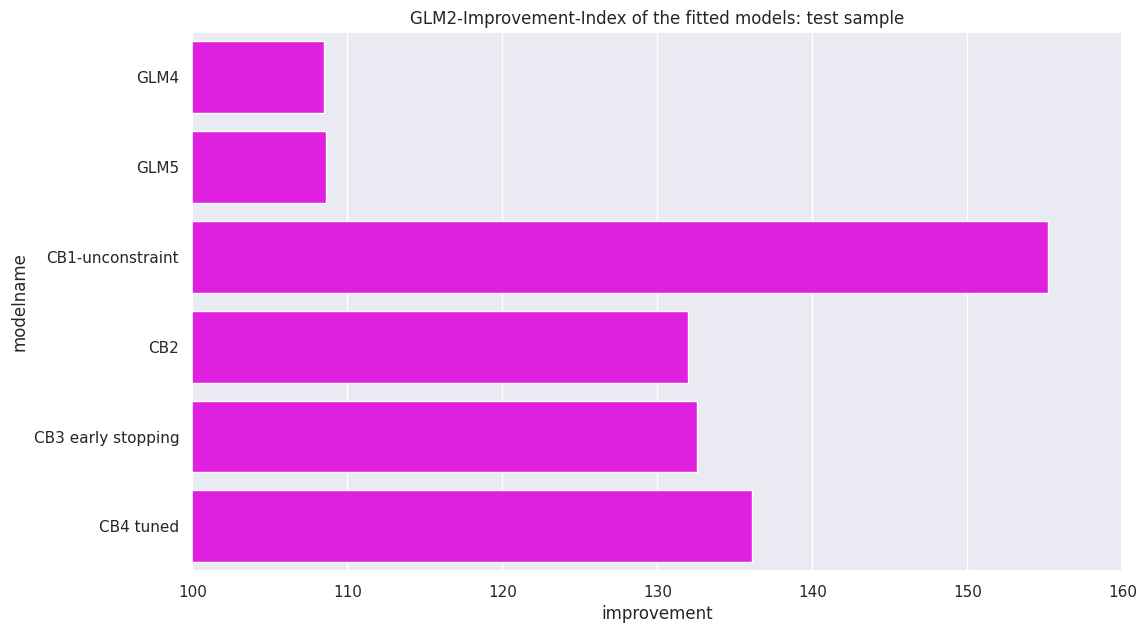

In [57]:
plot_eval(dict, 100, 160, "test sample")

### 3.5 Hyperparametertuning XGBoost (constraint)

#### 3.5.1 Basic XGBoost model

In [58]:
print('Execution on', device_XGB)

Execution on cpu


In [59]:
# Get feature names from the DataFrame
feature_names = X_learn.columns

# Define monotonic constraints dictionary (xgboost requires a dict.)
mtcd = {feature: 0 for feature in feature_names}  # Set all features to 0
mtcd[feature_names[3]] = 1  # Set the fourth feature to +1
X_learn.iloc[0:1, 3] # Check position in data frame

0    50
Name: BonusMalus, dtype: int64

In [60]:
model_xgb = XGBRegressor(device=device_XGB, objective = 'count:poisson', eval_metric='poisson-nloglik', 
                         tree_method = 'hist', monotone_constraints = mtcd, n_jobs=-1)

tic = time.time()
model_xgb.fit(X_learn, y_learn/learn.Exposure, sample_weight = learn.Exposure)
print("time (sec):" + "%6.0f" % (time.time() - tic))

learn["fitXGB"] = model_xgb.predict(X_learn) * learn.Exposure
test["fitXGB"] = model_xgb.predict(X_test) * test.Exposure

# Print claim frequency actual vs predicted
CF2("Claim Frequency XGB, Test-Sample, Actual/Predicted", test.ClaimNb, test.Exposure, test.fitXGB, test.Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance XGB", learn.fitXGB, learn.ClaimNb,learn.Exposure, test.fitXGB, test.ClaimNb,test.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark_GLM2("XGB", test.fitXGB)

time (sec):    15
Claim Frequency XGB, Test-Sample, Actual/Predicted: 7.38 % / 7.38 %
Poisson Deviance XGB, Learn/Test: 28.04 % / 28.99 %
GLM2-Improvement-Index (PD test) of XGB: 138.4 %


#### 3.5.2 HP-Tuning XGBoost: Fight Against Over-Fitting :-)

<img src="https://i.postimg.cc/PJmfRwry/T1-DALL-E-2023-10-21-22-00-27-Photorealistic-illustration-of-a-laughing-male-data-scientist-in-his.png" align="left" width="400">


As with Catboost, we perform a hyperparameter optimization with a grid search and cross-validation. To shorten the runtime, the grid is quite small. This was also preceded by a randomized search over a larger grid (not shown).

In [61]:
# Hyperparameter search range for lightGBM
param_grid_XGB ={'learning_rate': [0.04,0.05], 'max_depth':[4,5] }

# Variable list for displaying the CV result
sel_params_XGB = ['param_learning_rate','param_max_depth','mean_test_score','rank_test_score']

In [62]:
# XGBRegressor: Hyperparameter tuning with GridSearchCV
tic = time.time()

XGB_rs = GridSearchCV(XGBRegressor(n_estimators=500, tree_method='hist', device=device_XGB,
                                         objective="count:poisson", eval_metric="poisson-nloglik", 
                                         monotone_constraints = mtcd), 
                            param_grid_XGB, cv=4, n_jobs=-1)
                            
XGB_rs.fit(X=X_learn, y=y_learn/learn.Exposure, sample_weight=learn.Exposure)
           
#  Output runtime and best parameters (as well as the next best)
print("time (sec):" + "%6.0f" % (time.time() - tic))
print("Best parameters:",XGB_rs.best_params_)
pd.DataFrame(XGB_rs.cv_results_)[sel_params_XGB].sort_values("rank_test_score").head(5)

time (sec):   504
Best parameters: {'learning_rate': 0.04, 'max_depth': 5}


,param_learning_rate,param_max_depth,mean_test_score,rank_test_score
1,0.04,5,0.000532,1
3,0.05,5,0.000526,2
2,0.05,4,0.000525,3
0,0.04,4,0.000520,4


In [63]:
# Create new model on all folds with the best parameters
model_xgb2 = XGBRegressor(**XGB_rs.best_params_, n_estimators=500, tree_method='hist', device=device_XGB,
                          objective="count:poisson", eval_metric="poisson-nloglik", 
                          monotone_constraints=mtcd, n_jobs=-1, random_state=seed)    
model_xgb2.fit(X=X_learn, y=y_learn/learn.Exposure, sample_weight=learn.Exposure)

# make predictions
learn["fitXGB2"] = model_xgb2.predict(X_learn) * learn.Exposure
test["fitXGB2"] = model_xgb2.predict(X_test) * test.Exposure

# Print Poisson Deviance
PDW2('Poisson Deviance XGB2', learn.fitXGB2, learn.ClaimNb,learn.Exposure, test.fitXGB2,test.ClaimNb,test.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark_GLM2("XGB2 tuned", test.fitXGB2)

Poisson Deviance XGB2, Learn/Test: 28.62 % / 28.98 %
GLM2-Improvement-Index (PD test) of XGB2 tuned: 139.4 %


### 3.6 LightGBM (constraint)

#### 3.6.1 Basic LightGBM model

### 3.6 Basic LightGBM model (constraint)

In [64]:
print('Execution on', device_LGB)

Execution on cpu


In [65]:
model_lgbm = LGBMRegressor(device=device_LGB, objective="poisson", metric="poisson", 
                           monotone_constraints = mtc, n_jobs=-1, verbose=-1)

model_lgbm.fit(X=X_learn, y=y_learn/learn.Exposure, sample_weight=learn.Exposure)

# make predictions
learn["fitLGBM"] = model_lgbm.predict(X_learn) * learn.Exposure
test["fitLGBM"] = model_lgbm.predict(X_test) * test.Exposure

# Print Poisson Deviance
PDW2('Poisson Deviance LGBM', learn.fitLGBM, learn.ClaimNb,learn.Exposure, test.fitLGBM,test.ClaimNb,test.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark_GLM2("LGBM", test.fitLGBM)

Poisson Deviance LGBM, Learn/Test: 28.56 % / 28.98 %
GLM2-Improvement-Index (PD test) of LGBM: 139.3 %


#### 3.6.2 HP-Tuning LightGBM?

LightGBM performs remarkably well with the standard parameters (num_leaves=31, learning_rate=0.1, n_estimators=100). Attempts to improve this by means of hyperparameter tuning, as with CatBoost and XGBoost, were not successful. 

### 3.7 Comparing GBM models

#### 3.7.1 Model evaluation

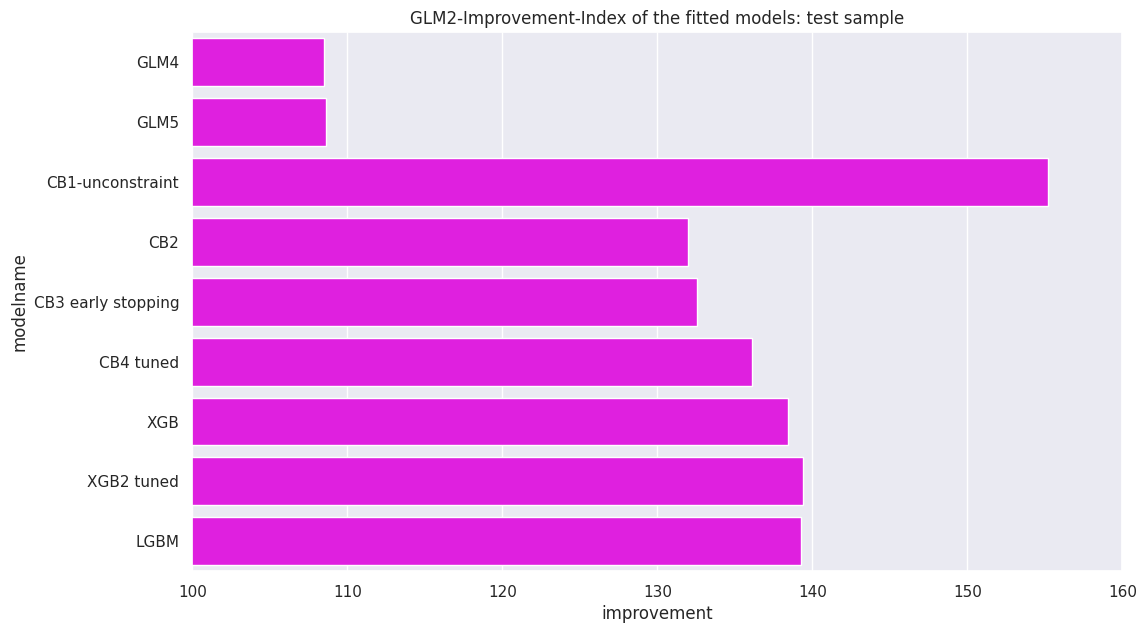

In [66]:
plot_eval(dict, 100, 160, "test sample")

The unrestricted catboost model CB1 is clearly the best. However, all other GBM models listed have a monotonic restriction to the most important feature BolusMalus as an exemplary consideration of a rate system. The best performing models are the hyperparameter tuned XGBoost model and the untuned LightGBM model. Both allow an improvement of up to 40%.

#### 3.7.1 Comparing feature importances 

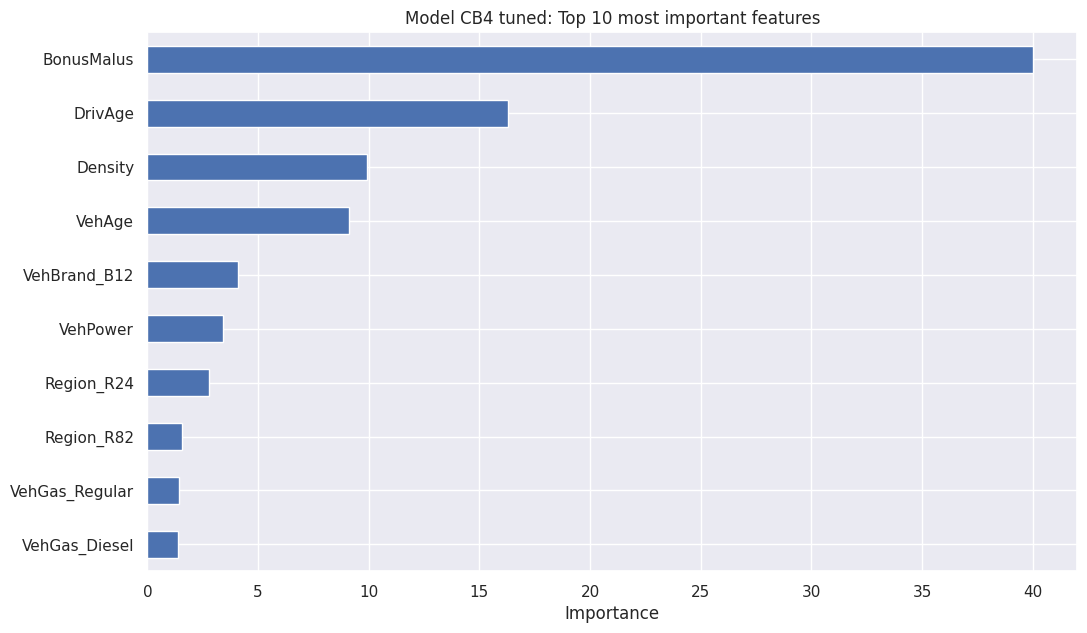

In [67]:
plot_feature_importance(model_cb4, X_learn, 10, "CB4 tuned")

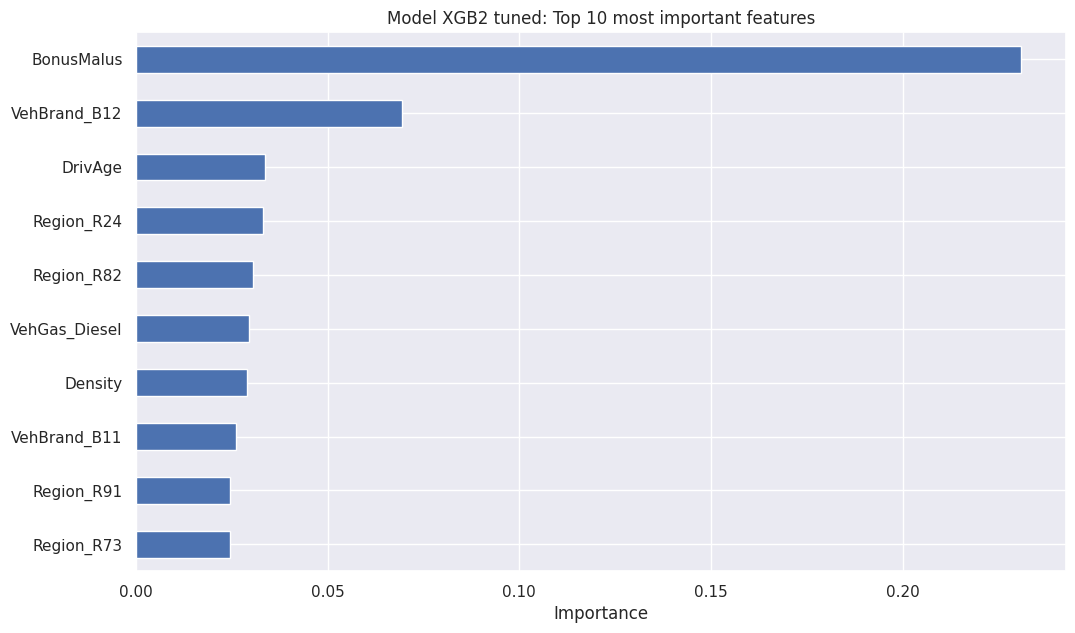

In [68]:
plot_feature_importance(model_xgb2, X_learn, 10, "XGB2 tuned")

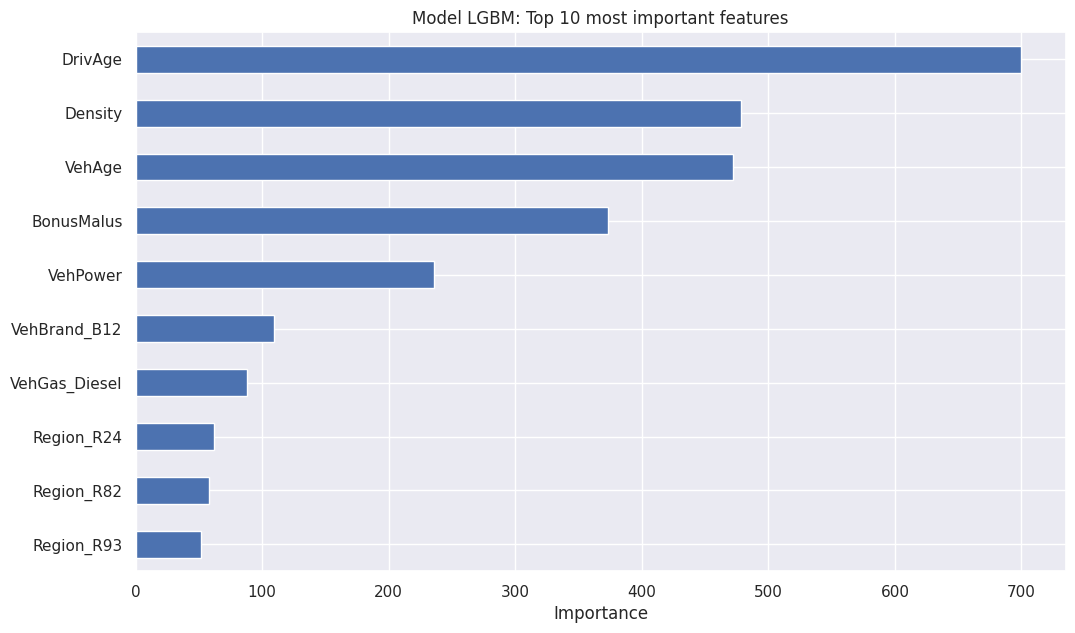

In [69]:
plot_feature_importance(model_lgbm, X_learn, 10, "LGBM")

While the feature importance of the CatBoost and XGBoost models look similar, LightGBM is surprisingly different and probably questionable. Therefore, we additionally calculate the SHAP values and create a SHAP summary plot:

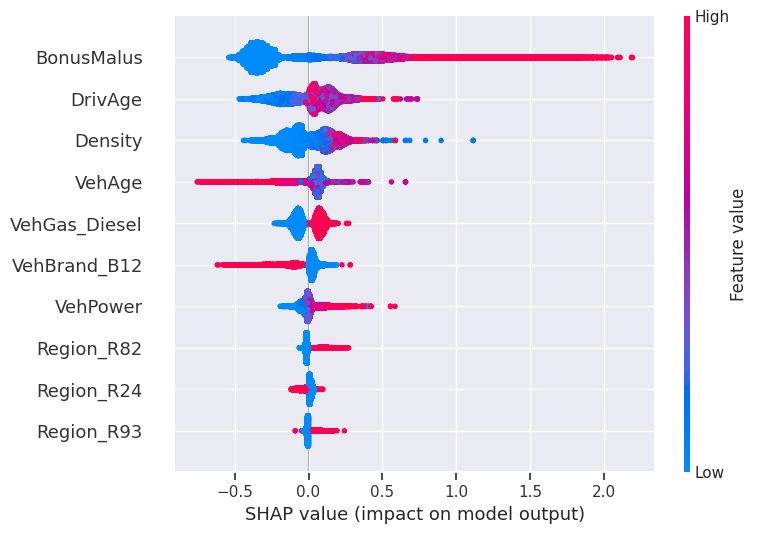

time (sec):    71


In [70]:
# define SHAP tree explainer for model_lgbm (default) and summarize the effects 
tic = time.time()
explainer_lgbm = shap.TreeExplainer(model_lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(X_test)
shap.summary_plot(shap_values_lgbm, X_test, max_display=10)
print("time (sec):" + "%6.0f" % (time.time() - tic))

In the SHAP summary plot of the LightGBM model, the "BonusMalus" feature is also the most important and therefore in line with CatBoost and XGBoost.  

<a id="A4"></a>
## 4. Deep Learning Approach with Embeddings and the "CANN"

<img src="https://i.postimg.cc/DZ45dC4H/DALL-E-2024-02-11-00-07-54-two-data-scientists-standing-on-gpu-YES-WE-CANN.webp" style="float: center; width: '100%'; max-width: '800px'">

This is basically a replication (see Acknowledgements) of the deep learning models published by Schelldorfer and Wüthrich (2019). The neural networks implemented are fairly small, the focus in this article is not on optimizing hyperparameters. Instead, very interesting ideas such as embeddings and the combined actuarial neural network (CANN) are demonstrated. For further information we recommend the article and the references therein. A brief overview can be found in this presentation (page 6 to 8): https://ethz.ch/content/dam/ethz/special-interest/math/risklab-dam/documents/risk-day/risk-day-2019/Schelldorfer_2019_09_11.pdf . In contrast, our CANN does not use the BonusMalus-feature in the neural network part to ensure monotonic behaviour.

In [71]:
import tensorflow
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, Embedding, Flatten, Add, concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, model_to_dot

2024-02-13 12:27:20.947221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 12:27:20.947352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 12:27:21.108946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 4.1 Pre-Processing

In [72]:
# feature pre-processing 

# min-max-scaler:
def PreProcess_Continuous(var1, dat2):
    var1X = f"{var1}X"
    if dat2[var1].dtype is np.dtype(np.object_):
            dat2[var1X] = dat2[var1].factorize()[0].astype(float)
    else:
        dat2[var1X] = dat2[var1].astype(float)
    dat2[var1X] = 2 * (dat2[var1X] - dat2[var1X].min())/(dat2[var1X].max()-dat2[var1X].min()) - 1
    return dat2


# pre-procecessing function:
def Features_PreProcess(dat2):
    dat2 = PreProcess_Continuous("Area", dat2)   
    dat2 = PreProcess_Continuous("VehPower", dat2)   
    dat2.VehAge = np.minimum(dat2.VehAge, 20)
    dat2 = PreProcess_Continuous("VehAge", dat2)   
    dat2.DrivAge = np.minimum(dat2.DrivAge, 90)
    dat2 = PreProcess_Continuous("DrivAge", dat2)   
    dat2.BonusMalus = np.minimum(dat2.BonusMalus, 150)
    dat2 = PreProcess_Continuous("BonusMalus", dat2)   
    dat2["VehBrandX"] = dat2.VehBrand.factorize()[0]
    dat2["VehGasX"] = dat2.VehGas.factorize()[0] - 0.5
    dat2.Density = np.round(np.log(dat2.Density), 2)
    dat2 = PreProcess_Continuous("Density", dat2)   
    dat2["RegionX"] = dat2.Region.factorize()[0]  # char R11,,R94 to number 0,,21
    return dat2

columns = ['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'fitGLM2','fold']
dat2 = Features_PreProcess(df[columns].copy())  # keep original variables and fitGLM2 (CANN)

dat2.iloc[:, 3:].sample(10)

,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fitGLM2,fold,AreaX,VehPowerX,VehAgeX,DrivAgeX,BonusMalusX,VehBrandX,VehGasX,DensityX,RegionX
428731,B,4,12,32,80,B2,Regular,4.49,R52,0.030321,1,-0.6,-1.000000,0.2,-0.611111,-0.40,3,-0.5,-0.119608,5
540822,E,4,12,65,50,B2,Diesel,9.14,R82,0.078037,1,-0.2,-1.000000,0.2,0.305556,-1.00,3,0.5,0.792157,0
582829,D,4,20,45,50,B1,Regular,6.45,R53,0.024749,2,-1.0,-1.000000,1.0,-0.250000,-1.00,9,-0.5,0.264706,13
201297,C,9,2,41,50,B12,Regular,5.58,R91,0.009051,1,0.2,-0.090909,-0.8,-0.361111,-1.00,0,-0.5,0.094118,4
294206,D,5,12,35,54,B5,Diesel,6.57,R52,0.053536,1,-1.0,-0.818182,0.2,-0.527778,-0.92,4,0.5,0.288235,5
520235,C,11,1,38,50,B12,Diesel,5.74,R82,0.061908,4,0.2,0.272727,-0.9,-0.444444,-1.00,0,0.5,0.125490,0
405222,A,5,2,39,50,B2,Diesel,3.43,R52,0.002494,1,1.0,-0.818182,-0.8,-0.416667,-1.00,3,0.5,-0.327451,5
604388,C,8,3,67,50,B3,Diesel,5.12,R94,0.072443,3,0.2,-0.272727,-0.7,0.361111,-1.00,2,0.5,0.003922,9
409448,C,4,15,55,50,B2,Regular,4.94,R31,0.003247,1,0.2,-1.000000,0.5,0.027778,-1.00,3,-0.5,-0.031373,3
266127,E,4,5,23,90,B1,Regular,8.17,R52,0.002757,4,-0.2,-1.000000,-0.5,-0.861111,-0.20,9,-0.5,0.601961,5


In [73]:
dat2.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fitGLM2,fold,AreaX,VehPowerX,VehAgeX,DrivAgeX,BonusMalusX,VehBrandX,VehGasX,DensityX,RegionX
0,1,0.0,0.10,D,5,0,55,50,B12,Regular,7.10,R82,0.005497,1,-1.0,-0.818182,-1.0,0.027778,-1.0,0,-0.5,0.392157,0
1,3,0.0,0.77,D,5,0,55,50,B12,Regular,7.10,R82,0.042330,5,-1.0,-0.818182,-1.0,0.027778,-1.0,0,-0.5,0.392157,0
2,5,0.0,0.75,B,6,2,52,50,B12,Diesel,3.99,R22,0.038299,1,-0.6,-0.636364,-0.8,-0.055556,-1.0,0,0.5,-0.217647,1
3,10,0.0,0.09,B,7,0,46,50,B12,Diesel,4.33,R72,0.003866,1,-0.6,-0.454545,-1.0,-0.222222,-1.0,0,0.5,-0.150980,2
4,11,0.0,0.84,B,7,0,46,50,B12,Diesel,4.33,R72,0.036084,2,-0.6,-0.454545,-1.0,-0.222222,-1.0,0,0.5,-0.150980,2


In [74]:
# choosing learning and test sample (based on folds)
learn = dat2.loc[dat2.fold != 5,].copy()     # 80%
test = dat2.loc[dat2.fold == 5,].copy()      # 20%
learn0 = learn.copy()
test0 = test.copy()
learn1 = learn.copy()
test1 = test.copy()
learn2 = learn.copy()
test2 = test.copy()

CF2("Claim Frequency (Actual) Learn/Test", learn.ClaimNb, learn.Exposure, test.ClaimNb, test.Exposure)

Claim Frequency (Actual) Learn/Test: 7.37 % / 7.38 %


In [75]:
# setting up the matrices

# definition of feature variables (non-categorical)
features = ['AreaX', 'VehPowerX', 'VehAgeX', 'DrivAgeX', 'BonusMalusX', 'VehGasX', 'DensityX']
q0 = len(features)

# learning data
Xlearn = learn[features]  # design matrix learning sample
Brlearn = learn.VehBrandX
Relearn = learn.RegionX
Ylearn = learn.ClaimNb

# testing data
Xtest = test[features]    # design matrix test sample
Brtest = test.VehBrandX
Retest = test.RegionX
Ytest = test.ClaimNb

# choosing the right volumes for EmbNN and CANN
Vlearn = np.log(learn.Exposure)
Vtest = np.log(test.Exposure)

print("Number of basic features (without VehBrand and Region):", q0)
lambda_hom = sum(learn.ClaimNb) / sum(learn.Exposure)

Number of basic features (without VehBrand and Region): 7


### 4.2 Setting up the Common Neural Network Architecture

In [76]:
# hyperparameters of the neural network architecture (as specified in "01 CANN approach.r") 
q1 = 20 # Number of neuron in hidden layer 1
q2 = 15
q3 = 10
d = 2   # dimensions embedding layers for categorical features
BrLabel = len(learn.VehBrandX.unique()) 
ReLabel = len(learn.RegionX.unique())

In [77]:
# define the network architecture
def define_model(q0, q1, q2, q3, d, BrLabel, ReLabel):
    Design = Input(shape=(q0,), dtype='float32', name='Design')
    VehBrand = Input(shape=(1,), dtype='int32', name='VehBrand')
    Region = Input(shape=(1,), dtype='int32', name='Region')
    LogVol = Input(shape=(1,), dtype='float32', name='LogVol')

    BrandEmb = Embedding(input_dim=BrLabel, output_dim=d, input_length=1, name='BrandEmb')(VehBrand)
    BrandEmb = Flatten(name="Brand_flat")(BrandEmb)

    RegionEmb = Embedding(input_dim=ReLabel, output_dim=d, input_length=1, name='RegionEmb')(Region)
    RegionEmb = Flatten(name='Region_flat')(RegionEmb)

    Network = concatenate([Design, BrandEmb, RegionEmb], name='concate')
    Network = Dense(units=q1, activation='tanh', name='hidden1')(Network)
    Network = Dense(units=q2, activation='tanh', name='hidden2')(Network)
    Network = Dense(units=q3, activation='tanh', name='hidden3')(Network)
    Network = Dense(units=1, activation='linear', name='Network', 
                    weights=[np.zeros(shape=(q3,1)), np.array([np.log(lambda_hom)])])(Network)

    Response = Add(name='Add')([Network, LogVol])
    Response = Dense(units=1, activation=K.exp, name='Response', trainable=False,
                     weights=[np.ones(shape=(1,1)), np.zeros(shape=(1,))])(Response)

    model = Model(inputs=[Design, VehBrand, Region, LogVol], outputs=[Response])
    return model

### 4.3 The Neural Network with Embeddings (NNemb)

Remark: To ensure reproducibility, we have set a "seed" once when determining the folds, namely for the `numpy` module, because a function of this module is used for splitting. We use the Tensorflow seed for the neural networks. It should be noted that this must be set for reproducibility before the models are defined, as the random initialisation of the weights (obviously) takes place here and not when the model is compiled.

In [78]:
# load model if already existing
try:
    model = load_model("CNNA.model", custom_objects={"exp": K.exp})
except Exception:
    # set seed again
    tensorflow.random.set_seed(seed)
    model = define_model(q0, q1, q2, q3, d, BrLabel, ReLabel)
    model.compile(optimizer=Nadam(), loss='poisson')
    model.summary()    # fitting the neural network (as specified in "01 CANN approach.r")
    start = time.time()
    fit = model.fit([Xlearn, Brlearn, Relearn, Vlearn], Ylearn, epochs=500, 
                           batch_size=10000, verbose=False, validation_split=0)
    print("time (sec):" + "%6.0f" % (time.time() - start))
    model.save("CNNA.model")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 VehBrand (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 Region (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 BrandEmb (Embedding)        (None, 1, 2)                 22        ['VehBrand[0][0]']            
                                                                                                  
 RegionEmb (Embedding)       (None, 1, 2)                 44        ['Region[0][0]']              
                                                                                              

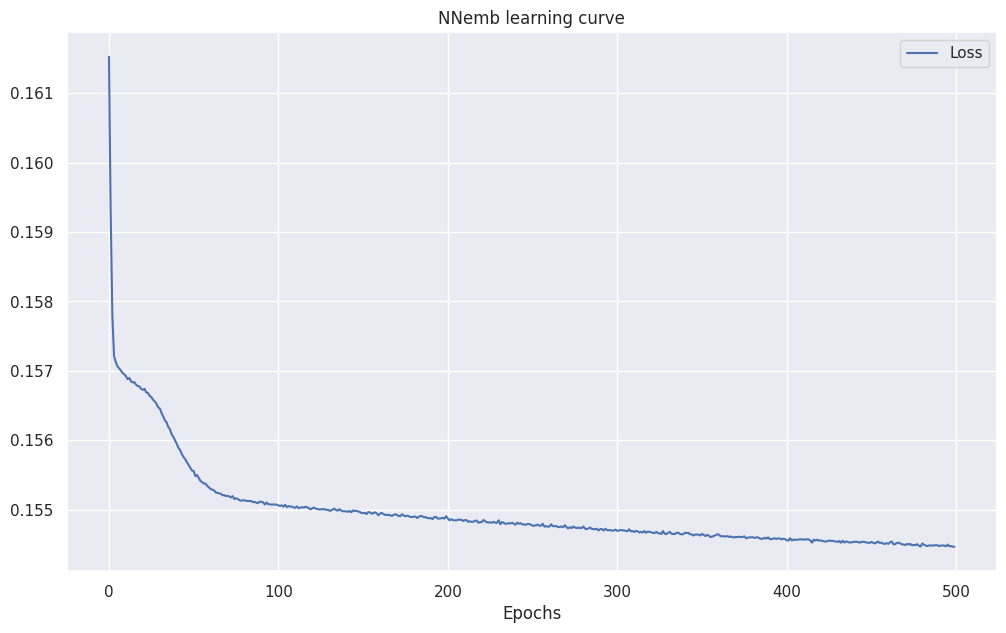

In [79]:
try:
    plot = pd.DataFrame(fit.history["loss"], columns=["Loss"], index=pd.Index(range(len(fit.history["loss"])), name="Epochs")).plot(title="NNemb learning curve")
    plot.figure.savefig("CNNA-loss.svg")
except Exception:
    pass

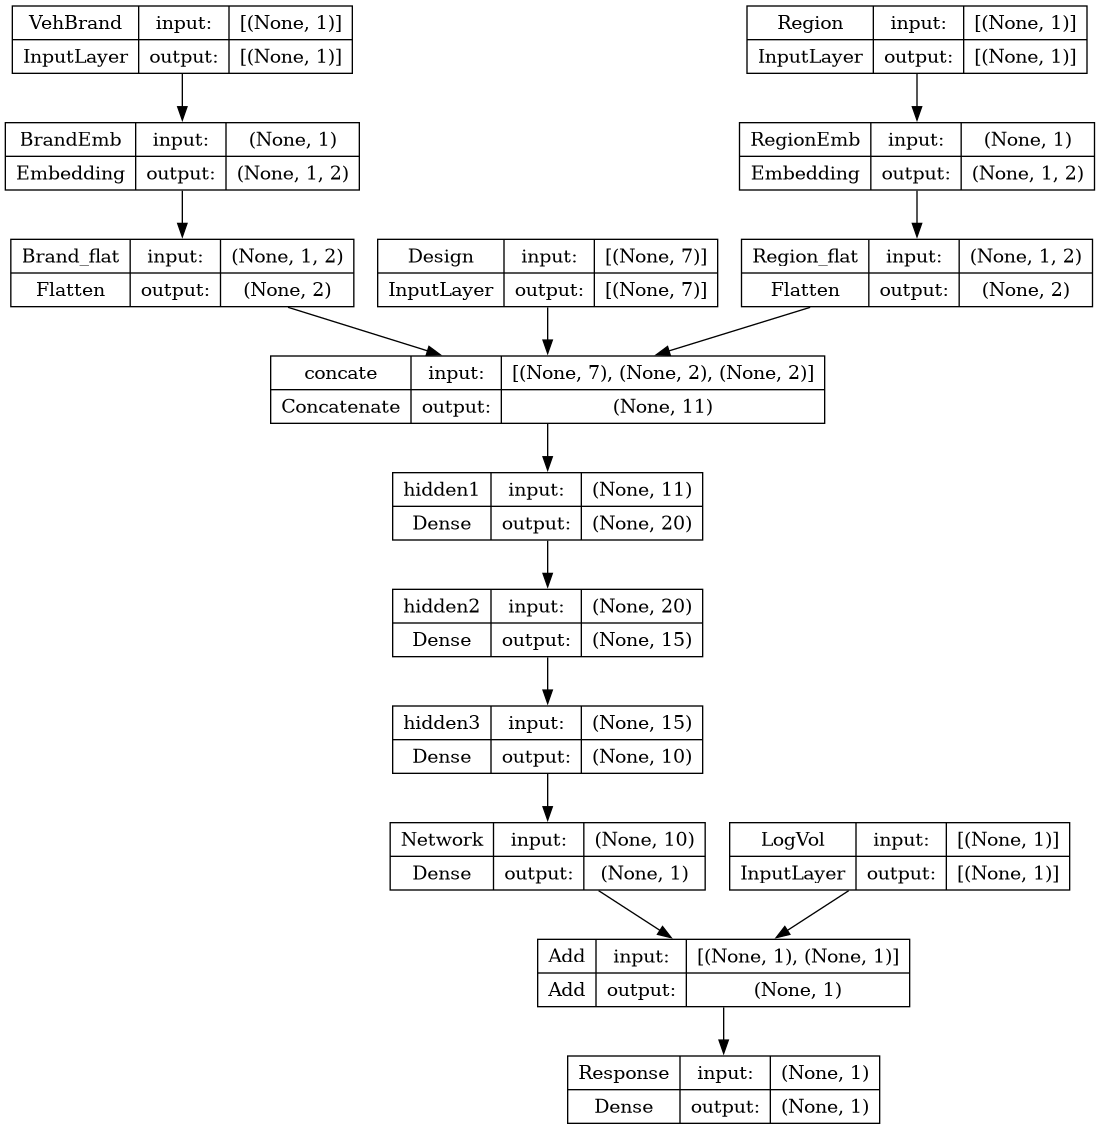

In [80]:
plot_model(model, to_file="CNNA.png", show_shapes=True)

In [81]:
dot = model_to_dot(model, show_shapes=True, dpi=48)
with open("CNNA.svg", "wb") as out:
    out.write(dot.create(prog='dot', format='svg'))

In [82]:
# calculating the predictions
learn0["fitNNemb"] = model.predict([Xlearn, Brlearn, Relearn, Vlearn])
test0["fitNNemb"] = model.predict([Xtest, Brtest, Retest, Vtest])

# Print claim frequency actual vs predicted
CF2("Claim Frequency NNemb, Test-Sample, Actual/Predicted", test0.ClaimNb, test0.Exposure, test0.fitNNemb, test0.Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance NNemb", learn0.fitNNemb, learn0.ClaimNb,learn.Exposure, test0.fitNNemb, test0.ClaimNb,test.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test2["fit_cf"] = test.Exposure * sum(learn.ClaimNb)/sum(learn.Exposure) # (recalculate INT-Model)
Benchmark_GLM2("NNemb-unconstraint", test0.fitNNemb)

4221/4221 [==============================] - 8s 2ms/step
Claim Frequency NNemb, Test-Sample, Actual/Predicted: 7.38 % / 7.41 %
Poisson Deviance NNemb, Learn/Test: 28.85 % / 29.12 %
GLM2-Improvement-Index (PD test) of NNemb-unconstraint: 129.8 %


#### Training with validation

In [83]:
# setting up the matrices

# definition of feature variables (non-categorical)
features = ['AreaX', 'VehPowerX', 'VehAgeX', 'DrivAgeX', 'BonusMalusX', 'VehGasX', 'DensityX']
q0 = len(features)

# learning data
Xlearn_train = learn.loc[learn.fold != 3][features]
Xlearn_val = learn.loc[learn.fold == 3][features]
Brlearn_train = learn.loc[learn.fold != 3].VehBrandX
Brlearn_val = learn.loc[learn.fold == 3].VehBrandX
Relearn_train = learn.loc[learn.fold != 3].RegionX
Relearn_val = learn.loc[learn.fold == 3].RegionX
Ylearn_train = learn.loc[learn.fold != 3].ClaimNb
Ylearn_val = learn.loc[learn.fold == 3].ClaimNb

# testing data
Xtest = test[features]    # design matrix test sample
Brtest = test.VehBrandX
Retest = test.RegionX
Ytest = test.ClaimNb

# choosing the right volumes for EmbNN and CANN
Vlearn_train = np.log(learn.loc[learn.fold != 3].Exposure)
Vlearn_val = np.log(learn.loc[learn.fold == 3].Exposure)
Vtest = np.log(test.Exposure)

print("Number of basic features (without VehBrand and Region):", q0)
lambda_hom = sum(learn.ClaimNb) / sum(learn.Exposure)

Number of basic features (without VehBrand and Region): 7


In [84]:
# hyperparameters of the neural network architecture (as specified in "01 CANN approach.r") 
q1 = 20 # Number of neuron in hidden layer 1
q2 = 15
q3 = 10
d = 2   # dimensions embedding layers for categorical features
BrLabel = len(learn.VehBrandX.unique()) 
ReLabel = len(learn.RegionX.unique())

In [85]:
# load model if already existing
try:
    model_val = load_model("CNNA_val.model", custom_objects={"exp": K.exp})
except Exception:
    # set seed again
    tensorflow.random.set_seed(seed)
    model_val  = define_model(q0, q1, q2, q3, d, BrLabel, ReLabel)
    model_val.compile(optimizer=Nadam(), loss='poisson')
    # fitting the neural network with validation_loss
    start = time.time()
    fit_val = model_val.fit([Xlearn_train, Brlearn_train, Relearn_train, Vlearn_train], Ylearn_train, epochs=1000,
                            batch_size=10000, verbose=False, 
                            validation_data=([Xlearn_val, Brlearn_val, Relearn_val, Vlearn_val], Ylearn_val),
                            callbacks=[EarlyStopping(patience=50, verbose=True)],
                           )
    print("time (sec):" + "%6.0f" % (time.time() - start))
    model_val.save("CNNA_val.model")

Epoch 306: early stopping
time (sec):   127


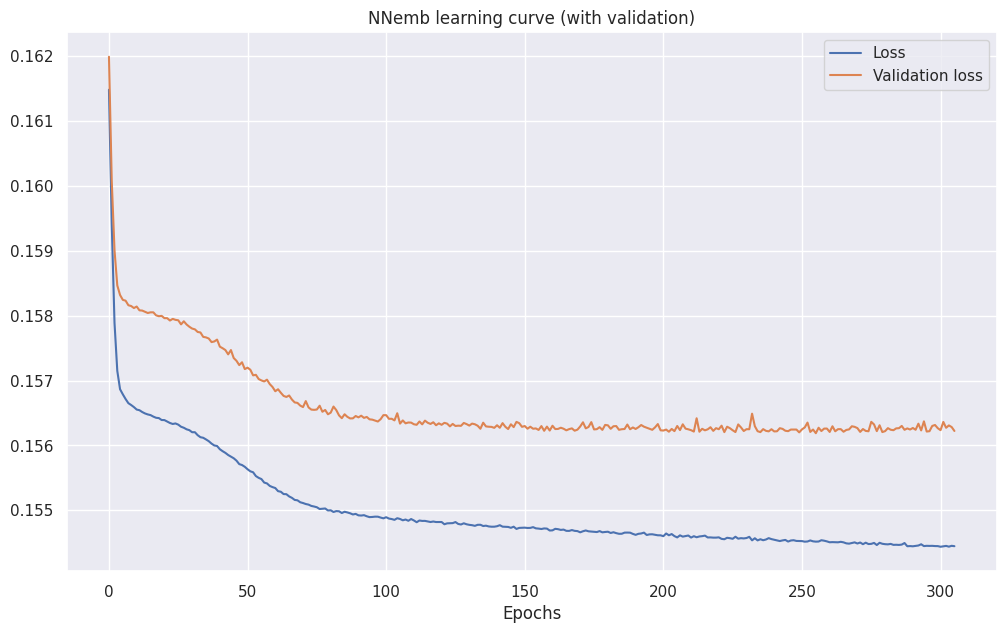

In [86]:
try:
    plot = pd.DataFrame.from_dict({"Loss": fit_val.history["loss"],
                                       "Validation loss": fit_val.history["val_loss"],
                                      })
    plot.index.name = "Epochs"
    plot = plot.plot(title="NNemb learning curve (with validation)")
    plot.figure.savefig("CNNA-loss_val.svg")
except Exception:
    SVG(filename="CNNA-loss_val.svg")

In [87]:
# calculating the predictions
learn0["fitNNemb"] = model.predict([learn[features], learn.VehBrandX, learn.RegionX, np.log(learn.Exposure)])
test0["fitNNemb"] = model.predict([Xtest, Brtest, Retest, Vtest])

# Print claim frequency actual vs predicted
CF2("Claim Frequency NNemb, Test-Sample, Actual/Predicted", test0.ClaimNb, test0.Exposure, test0.fitNNemb, test0.Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance NNemb", learn0.fitNNemb, learn0.ClaimNb,learn.Exposure, test0.fitNNemb, test0.ClaimNb,test.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test["fit_cf"] = test.Exposure * sum(learn.ClaimNb)/sum(learn.Exposure) # (recalculate INT-Model)
Benchmark_GLM2("NNemb-unconstraint", test0.fitNNemb)

4221/4221 [==============================] - 6s 1ms/step
Claim Frequency NNemb, Test-Sample, Actual/Predicted: 7.38 % / 7.41 %
Poisson Deviance NNemb, Learn/Test: 28.85 % / 29.12 %
GLM2-Improvement-Index (PD test) of NNemb-unconstraint: 129.8 %


### 4.4 Visualize Embeddings

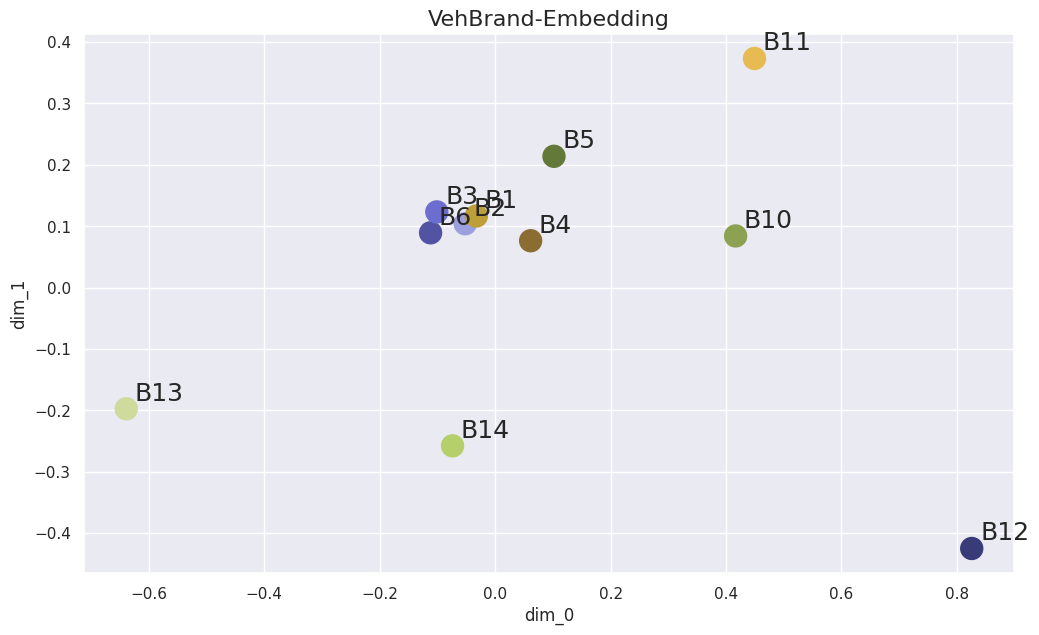

In [88]:
# get weights for VehBrand:
emb_B = model.layers[2] 
emb_B = pd.DataFrame(emb_B.get_weights()[0], columns=["dim_0", "dim_1"])
emb_B["VehBrand"] = learn.groupby("VehBrandX").VehBrand.last()
emb_B = emb_B.set_index("VehBrand")

# plot embedding
ax = emb_B.plot(kind="scatter", x="dim_0", y="dim_1", c=plt.get_cmap("tab20b").colors[:len(emb_B)], s=250)

def annotate(row, ax=ax):
    ax.annotate(row.name, row.values[:2],
                xytext=(6,6),
                textcoords="offset points",
                size=18,
               )
emb_B.apply(annotate, axis="columns")
plt.title("VehBrand-Embedding", fontdict={"fontsize": 16})
plt.show()

In [89]:
# get weights for Region:
emb_R = model.layers[3] # Region
emb_R = pd.DataFrame(emb_R.get_weights()[0], columns=["dim_0", "dim_1"])
emb_R["Region"] = learn.groupby("RegionX").Region.last()
emb_R = emb_R.set_index("Region")
emb_R = emb_R.sort_index()

In [90]:
# Dictionary for region names
regions_by_name = {'Alsace': 'R42',
                   'Aquitaine': 'R72',
                   'Auvergne': 'R83',
                   'Île-de-France': 'R11',
                   'Basse-Normandie': 'R25',
                   'Bourgogne': 'R26',
                   'Bretagne': 'R53',
                   'Centre': 'R24',
                   'Champagne-Ardenne': 'R21',
                   'Corse': 'R94',
                   'Franche-Comté': 'R43',
                   'Haute-Normandie': 'R23',
                   'Languedoc-Roussillon': 'R91',
                   'Limousin': 'R74',
                   'Lorraine': 'R41',
                   'Midi-Pyrénées': 'R73',
                   'Nord-Pas-de-Calais': 'R31',
                   'Pays de la Loire': 'R52',
                   'Picardie': 'R22',
                   'Poitou-Charentes': 'R54',
                   "Provence-Alpes-Côte d'Azur": 'R93',
                   'Rhône-Alpes': 'R82'}

regions_by_code = {val: key for key, val in sorted(regions_by_name.items(), key=lambda x: x[1])}

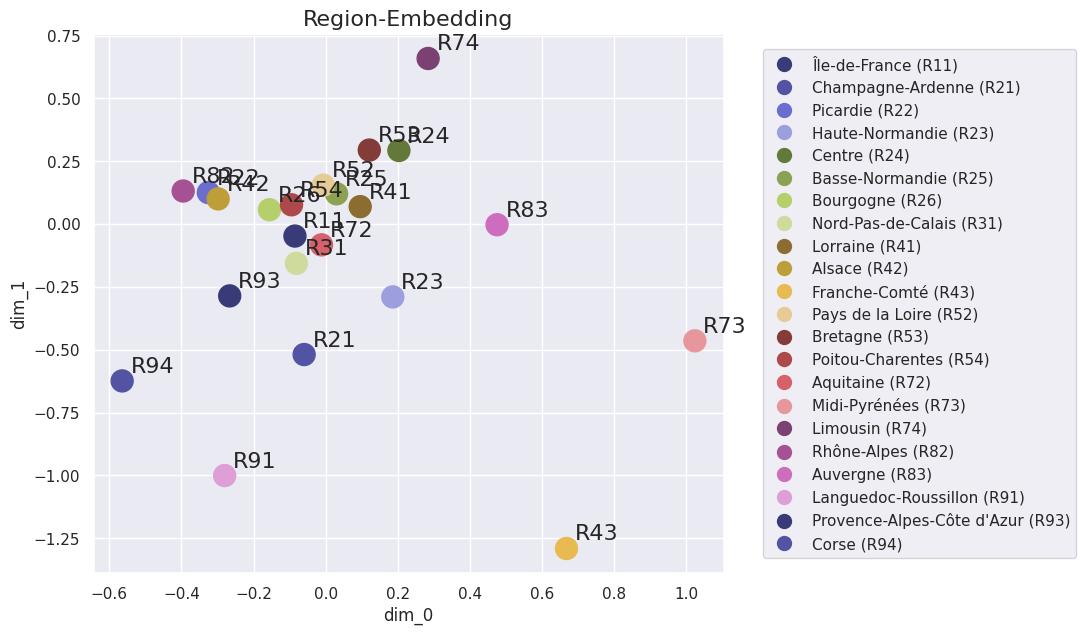

In [91]:
# plot regional embedding
import matplotlib.patches as mpatches

ax = emb_R.plot(kind="scatter", x="dim_0", y="dim_1", c=(2*plt.get_cmap("tab20b").colors)[:len(emb_R)], s=250)

def annotate(row, ax=ax):
    ax.annotate(row.name, row.values[:2],
                xytext=(6,6),
                textcoords="offset points",
                size=16,
               )
emb_R.apply(annotate, axis="columns")

patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=(2*plt.get_cmap("tab20b").colors)[i])[0] for i, key in enumerate(emb_R.index)]
ax.legend(handles=patches, labels=[f"{regions_by_code[key]} ({key})" for key in emb_R.index], bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.subplots_adjust(right=0.65)
plt.title("Region-Embedding", fontdict={"fontsize": 16})
plt.show()
ax.figure.savefig("Embbedding_Region.svg")

### 4.5 "The CANN": Combined Actuarial Neural Network with GLM2

Now we will boost GLM2 with the neural network from above to form a combined actuarial neural network (CANN). The idea behind boosting is to analyse the residuals of a given regression model with a complex and flexible second model to see if this second model can still find systematic effects in the residuals that were not detected by the first model. Technically, the exposure is replaced by the predicted values of GLM2. 

In contrast to the CANN implmented by Schelldorfer & Wüthrich (2019), our CANN does not use the BonusMalus-feature in the neural network part to ensure monotonic behaviour.

In [92]:
# setting up the matrices

# definition of feature variables (non-categorical)
features = ['AreaX', 'VehPowerX', 'VehAgeX', 'DrivAgeX', 'VehGasX', 'DensityX']
q0 = len(features)

# learning data
Xlearn = learn[features]  # design matrix learning sample
Brlearn = learn.VehBrandX
Relearn = learn.RegionX
Ylearn = learn.ClaimNb

# testing data
Xtest = test[features]    # design matrix test sample
Brtest = test.VehBrandX
Retest = test.RegionX
Ytest = test.ClaimNb

# choosing the right volumes for NNEmb and CANN
Vlearn = np.log(learn.Exposure)
Vtest = np.log(test.Exposure)

print("Number of basic features (without VehBrand and Region):", q0)
lambda_hom = sum(learn.ClaimNb) / sum(learn.Exposure)

Number of basic features (without VehBrand and Region): 6


In [93]:
# Incorporating model GLM2 into a CANN (instead of Exposure)
Vlearn = np.log(learn.fitGLM2)
Vtest = np.log(test.fitGLM2)
lambda_hom = sum(learn.ClaimNb) / sum(learn.fitGLM2)
lambda_hom

1.0000000000000309

In [94]:
# load model if already existing
try:
    model = load_model("CANN7.model", custom_objects={"exp": K.exp})
except OSError:
    # set seed again
    tensorflow.random.set_seed(seed)
    model = define_model(q0, q1, q2, q3, d, BrLabel, ReLabel)
    model.compile(optimizer=Nadam(), loss='poisson')
    model.summary()    # fitting the neural network (as specified in "01 CANN approach.r")
    start = time.time()
    fit = model.fit([Xlearn, Brlearn, Relearn, Vlearn], Ylearn, epochs=250, 
                           batch_size=10000, verbose=False, validation_split=0)
    print("time (sec):" + "%6.0f" % (time.time() - start))
    model.save("CANN.model")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 VehBrand (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 Region (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 BrandEmb (Embedding)        (None, 1, 2)                 22        ['VehBrand[0][0]']            
                                                                                                  
 RegionEmb (Embedding)       (None, 1, 2)                 44        ['Region[0][0]']              
                                                                                            

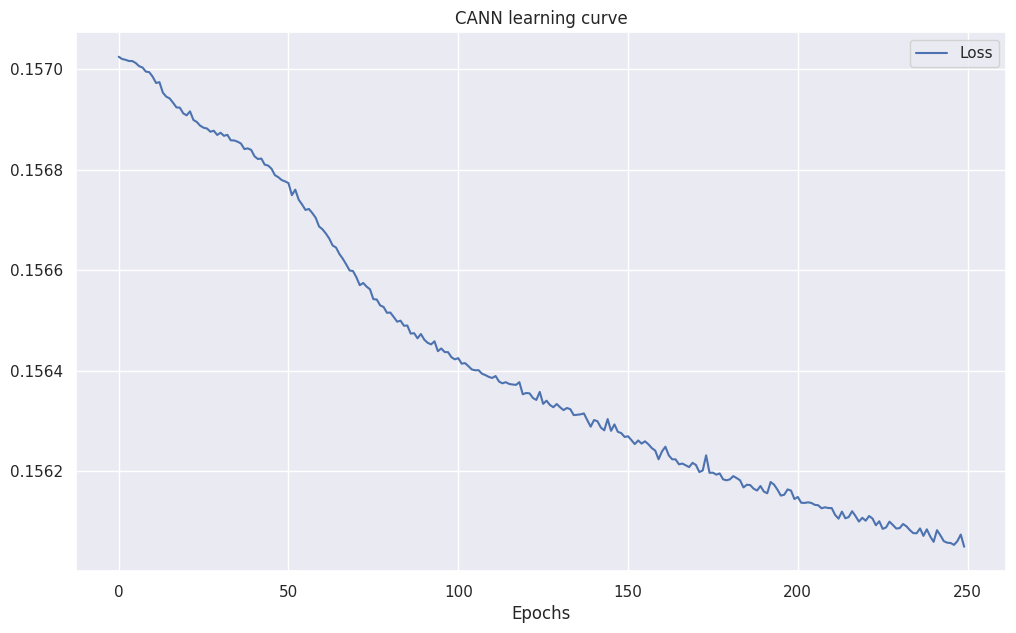

In [95]:
try:
    plot = pd.DataFrame.from_dict({"Loss": fit.history["loss"]})
    plot.index.name = "Epochs"
    plot = plot.plot(title="CANN learning curve")
    plot.figure.savefig("CANN-loss.svg")
except Exception:
    SVG(filename="CANN-loss.svg")

In [96]:
# calculating the predictions
learn1["fitCANN"] = model.predict([Xlearn, Brlearn, Relearn, Vlearn])
test1["fitCANN"] = model.predict([Xtest, Brtest, Retest, Vtest])

# Print claim frequency actual vs predicted
CF2("Claim Frequency CANN, Test-Sample, Actual/Predicted", test1.ClaimNb, test1.Exposure, test1.fitCANN, test1.Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance CANN", learn1.fitCANN, learn1.ClaimNb,learn.Exposure, test1.fitCANN, test1.ClaimNb,test.Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test2["fit_cf"] = test.Exposure * sum(learn.ClaimNb)/sum(learn.Exposure) # (recalculate INT-Model)
Benchmark_GLM2("CANN", test1.fitCANN)

4221/4221 [==============================] - 7s 2ms/step
Claim Frequency CANN, Test-Sample, Actual/Predicted: 7.38 % / 7.27 %
Poisson Deviance CANN, Learn/Test: 29.35 % / 29.51 %
GLM2-Improvement-Index (PD test) of CANN: 104.0 %


This may be improved by tuning the hyperparameters. Since alternative models are available to us that are quite easy to handle and work immediately, such as the gradient tree boosting tools considered in Chapter 3, we decide against pursuing the artificial neural network approach further and have thus reached the end of our modeling approaches.

<a id="A5"></a>
## 5. Summary and Outlook

The following diagram shows the improvement potential of all models compared to a simple generalized linear model:

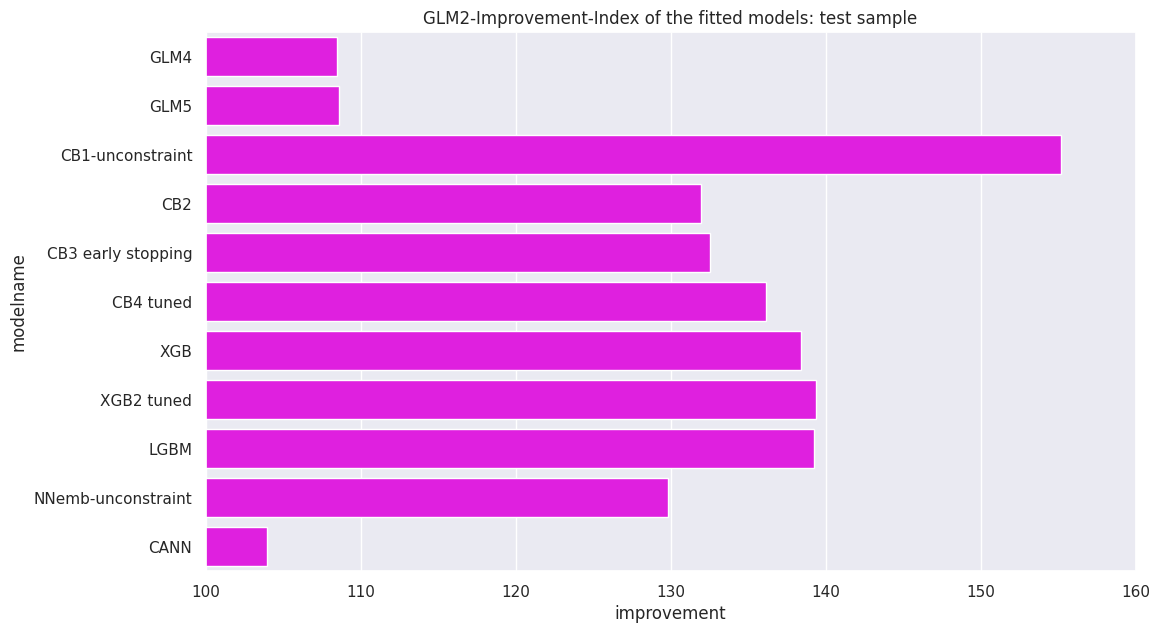

In [97]:
plot_eval(dict, 100, 160, "test sample")

The diagram contains three classes of models. First, two generalized linear models with interaction terms (GLM4, GLM5), where we find a limited improvement potential of less than 10 % compared to our benchmark model GLM2. This is followed by seven gradient tree boosting models. Finally, two artificial neural networks, where the unconstrained neural network with embedding performs quite well, but is far outperformed by the unconstrained catboost model CB1. However, all other GBM models listed have a monotonic restriction to the most important feature BolusMalus as an exemplary consideration of a tariff system. The best performing models are the hyperparameter tuned XGBoost model and the untuned LightGBM model. Both allow an improvement of up to 40%.

The results of this notebook will be incorporated into an upcoming new version of the corresponding R notebook, in which further application aspects and in particular the benefits for the development of improved GLMs will be discussed.

**Acknowledgements:** Chapter 4 is originally based on R codes written by Mario Wüthrich, which were ported to Python (years before ChatGPT) and extended with embedding plots by Axel Kaiser. So a big THANK YOU to both and all the other great contributors to open source and especially actuarial data science codes.